# Tennis Betting -- Can we profit from bookmakers?

<a id='Contents'></a> 
## Contents

### 1. [Objectives](#objectives)
### 2. [Combining Data](#combdata)
### 3. [Comparing Bookmakers](#compbm)
### 4. [Betting Strategies](#bs)
### 5. [Performance Comparison](#performance)
### 6. [Summary](#summary)

<a id='objectives'></a>
 ##  1. [Objectives](#Contents)

In this notebook, we will use the winner prediction result from our tennis analysis and modeling project \bf{'Tennis ATP data Exploration and Modeling'}, as well as the odds provided by tennis bookmakers at https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/ to identify if there is a profitable betting stradegy.

We will use information of the betting odds from bookmakers and the predicted probabilities from the machine learning model to determine whether to bet on a game and how much to bet. We will use the data from 2012 - 2020 to evaluate the averaged profit rates of different betting strategies. 

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
import os
import string    
from itertools import product
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBRegressor
from xgboost import plot_importance
import time
import sys
import gc
import pickle
sys.version_info
import zipfile
import urllib

In [2]:
#https://svaderia.github.io/articles/downloading-and-unzipping-a-zipfile/
from urllib.request import urlopen
from tempfile import NamedTemporaryFile
from shutil import unpack_archive
    
import statistics
from time import sleep
import sys

<a id='combdata'></a>
 ##  2. [Combine Data](#Contents)

In [4]:
# download the data from  https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/
matrix_bt = pd.DataFrame()
    
url = "http://tennis-data.co.uk/"

year_range = np.arange(2000,2021)

for year in year_range:
    
    file_url = url+str(year)+'/'+str(year)+'.zip'

    filehandle, _ = urllib.request.urlretrieve(file_url)
    zip_file_object = zipfile.ZipFile(filehandle, 'r')
    first_file = zip_file_object.namelist()[0]
    file = zip_file_object.open(first_file)
    df = pd.read_excel(file, sheet_name=None)[str(year)]
    
    if year==year_range[0]:
        cols = df.columns
    
    matrix_bt = pd.concat([matrix_bt, df], ignore_index=True, sort=False, keys=cols)

In [5]:
#matrix_bt.to_pickle('matrix_bet.pkl')                       

In [4]:
matrix_bt = pd.read_pickle('matrix_bet.pkl')
matrix_bt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55669 entries, 0 to 55668
Data columns (total 54 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         55669 non-null  float64       
 1   Location    55669 non-null  object        
 2   Tournament  55669 non-null  object        
 3   Date        55669 non-null  datetime64[ns]
 4   Series      55669 non-null  object        
 5   Court       55669 non-null  object        
 6   Surface     55669 non-null  object        
 7   Round       55669 non-null  object        
 8   Best of     55669 non-null  float64       
 9   Winner      55669 non-null  object        
 10  Loser       55669 non-null  object        
 11  WRank       55649 non-null  object        
 12  LRank       55573 non-null  object        
 13  W1          55381 non-null  float64       
 14  L1          55383 non-null  float64       
 15  W2          54854 non-null  object        
 16  L2          54855 non-

We see that Bet365(B365) and  Pinnacle (PS) have most non-null data points, we shall focus on these two bookmakers.

Import the result from out machine learning model

In [6]:
matrix_p = pd.read_pickle("./tennis_matrix2_n_elo.pkl")
matrix_p = matrix_p[(matrix_p.year<=2020)&(matrix_p.year>=2010)]
if 'key_0' in matrix_p.columns:
    matrix_p = matrix_p.drop(columns='key_0',axis=1)
    
matrix_p.head()

,tourney_name,surface,draw_size,tourney_level,tourney_date,year,month,day,day_week,match_num,best_of,round,minutes,p1_id,p1_seed,p1_entry,p1_name,p1_hand,p1_ht,p1_ioc,p1_age,p2_id,p2_seed,p2_entry,p2_name,p2_hand,p2_ht,p2_ioc,p2_age,p1_win,p2_win,p1_rank,p1_rank_points,p1_ace,p1_df,p1_svpt,p1_1stIn,p1_1stWon,p1_2ndWon,p1_SvGms,p1_bpFaced,p1_bpSaved,p1_bpc,p1_bpsr,p1_bpcr,p1_set_1,p1_set_2,p1_set_3,p1_set_4,p1_set_5,...,Elo_sf_rp_win6m_seed,Elo_sf_rp_win6m_seed_winratio,Elo_bpcr_bpsr_ace_df_1stwon_2ndwon,win_1_4m,ace_1_4m,df_1_4m,1stWon_1_4m,2ndWon_1_4m,bpsr_1_4m,bpcr_1_4m,win_1_6m,ace_1_6m,df_1_6m,1stWon_1_6m,2ndWon_1_6m,bpsr_1_6m,bpcr_1_6m,win_1_8m,ace_1_8m,df_1_8m,1stWon_1_8m,2ndWon_1_8m,bpsr_1_8m,bpcr_1_8m,win_2_4m,ace_2_4m,df_2_4m,1stWon_2_4m,2ndWon_2_4m,bpsr_2_4m,bpcr_2_4m,win_2_6m,ace_2_6m,df_2_6m,1stWon_2_6m,2ndWon_2_6m,bpsr_2_6m,bpcr_2_6m,win_2_8m,ace_2_8m,df_2_8m,1stWon_2_8m,2ndWon_2_8m,bpsr_2_8m,bpcr_2_8m,Elo_sf_rp_win6m_winratio,bpcr_bpsr_ace_1stwon_2ndwon_6m,bpcr_bpsr_ace_1stwon_2ndwon_last_10,win_ratio_1-2_last_10,win_ratio_1-2_last_20
105738,Brisbane,Hard,32.0,A,2010-01-03,2010,1,3,6,1.0,3,R32,84.0,103429.0,NaN,NaN,Peter Luczak,R,183.0,AUS,30.346338,104053.0,1,NaN,Andy Roddick,R,188.0,USA,27.348392,0.0,1.0,77.0,598.0,4.0,2.0,56.0,34.0,29.0,11.0,10.0,5.0,3.0,0.0,0.600000,0.000000,6.0,2.0,NaN,NaN,NaN,...,NaN,NaN,-0.004953,1.0,34.0,19.0,164.0,74.0,2.375000,1.194444,2.0,42.0,23.0,248.0,122.0,4.213235,2.319444,2.0,42.0,23.0,248.0,122.0,4.213235,2.319444,0.0,9.0,4.0,37.0,9.0,0.444444,0.500000,9.0,148.0,23.0,625.0,215.0,7.384127,7.238889,23.0,447.0,50.0,1570.0,492.0,16.023990,12.388095,NaN,0.015561,NaN,NaN,NaN
105739,Brisbane,Hard,32.0,A,2010-01-03,2010,1,3,6,2.0,3,R32,70.0,104958.0,NaN,WC,Carsten Ball,L,198.0,AUS,22.543463,104999.0,NaN,NaN,Mischa Zverev,L,190.0,GER,22.370979,1.0,0.0,134.0,400.0,10.0,3.0,57.0,30.0,23.0,19.0,10.0,0.0,0.0,3.0,NaN,0.300000,7.0,6.0,NaN,NaN,NaN,...,NaN,NaN,-0.004953,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,5.0,73.0,26.0,220.0,117.0,4.706349,3.541667,5.0,73.0,26.0,220.0,117.0,4.706349,3.541667,1.0,24.0,7.0,212.0,65.0,3.523810,1.408333,3.0,59.0,28.0,534.0,197.0,9.841558,4.907234,6.0,89.0,39.0,796.0,284.0,14.355844,7.548901,NaN,0.026840,NaN,NaN,NaN
105740,Brisbane,Hard,32.0,A,2010-01-03,2010,1,3,6,3.0,3,R32,121.0,103813.0,NaN,NaN,Jarkko Nieminen,L,185.0,FIN,28.451745,104755.0,NaN,NaN,Richard Gasquet,R,185.0,FRA,23.548255,0.0,1.0,88.0,568.0,4.0,0.0,85.0,58.0,38.0,14.0,14.0,11.0,7.0,3.0,0.636364,0.375000,3.0,6.0,4.0,NaN,NaN,...,NaN,NaN,-0.004966,4.0,13.0,9.0,136.0,49.0,1.880952,3.300000,5.0,25.0,18.0,239.0,111.0,3.205739,4.061905,5.0,25.0,18.0,239.0,111.0,3.205739,4.061905,8.0,109.0,40.0,462.0,220.0,8.739286,4.317216,8.0,113.0,44.0,491.0,232.0,9.239286,4.317216,8.0,113.0,44.0,491.0,232.0,9.239286,4.317216,-0.045001,0.023431,-0.51863,-1.0,-1.0
105741,Brisbane,Hard,32.0,A,2010-01-03,2010,1,3,6,4.0,3,R32,64.0,103781.0,6,NaN,Jurgen Melzer,L,183.0,AUT,28.621492,105051.0,NaN,Q,Matthew Ebden,R,188.0,AUS,22.108145,0.0,1.0,28.0,1260.0,2.0,1.0,53.0,29.0,16.0,15.0,9.0,5.0,2.0,0.0,0.400000,0.000000,5.0,1.0,NaN,NaN,NaN,...,NaN,NaN,0.294772,12.0,126.0,20.0,440.0,214.0,9.333333,5.340079,20.0,198.0,52.0,951.0,427.0,17.433372,10.535823,29.0,318.0,91.0,1410.0,658.0,24.034310,17.017890,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,0.243655,NaN,NaN,NaN
105742,Brisbane,Hard,32.0,A,2010-01-03,2010,1,3,6,5.0,3,R32,69.0,104607.0,4,NaN,Tomas Berdych,R,196.0,CZE,24.298426,105194.0,NaN,Q,Nick Lindahl,R,183.0,AUS,21.429158,1.0,0.0,20.0,1655.0,3.0,1.0,46.0,27.0,24.0,14.0,9.0,1.0,1.0,3.0,1.000000,0.333333,6.0,6.0,NaN,NaN,NaN,...,NaN,NaN,0.190843,9.0,77.0,28.0,388.0,188.0,6.392308,5.375275,17.0,165.0,68.0,800.0,462.0,13.881546,9.631371,22.0,250.0,88.0,1156.0,622.0,19.016070,13.050635,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,0.148277,NaN,NaN,NaN


We focus on comparing Bet365 (B365) and Pinnacle (PS)

In [176]:
matrix_0 = matrix_bt[['Location','Tournament','Winner','Date','Loser','B365W','B365L','PSW','PSL','L1','L2']]
matrix_0['year']=matrix_0['Date'].dt.year
matrix_0['month']=matrix_0['Date'].dt.month
matrix_0['day']=matrix_0['Date'].dt.day
matrix_0.head(5)

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 

,Location,Tournament,Winner,Date,Loser,B365W,B365L,PSW,PSL,L1,L2,year,month,day
0,Adelaide,Australian Hardcourt Championships,Dosedel S.,2000-01-03,Ljubicic I.,NaN,NaN,NaN,NaN,4.0,2,2000,1,3
1,Adelaide,Australian Hardcourt Championships,Enqvist T.,2000-01-03,Clement A.,NaN,NaN,NaN,NaN,3.0,3,2000,1,3
2,Adelaide,Australian Hardcourt Championships,Escude N.,2000-01-03,Baccanello P.,NaN,NaN,NaN,NaN,7.0,5,2000,1,3
3,Adelaide,Australian Hardcourt Championships,Federer R.,2000-01-03,Knippschild J.,NaN,NaN,NaN,NaN,1.0,4,2000,1,3
4,Adelaide,Australian Hardcourt Championships,Fromberg R.,2000-01-03,Woodbridge T.,NaN,NaN,NaN,NaN,6.0,7,2000,1,3


Here we can see the data from the two sources have different numbers of records during the same time period. We merge the information from the dataframe with prediction information: matrix_p with the dataframe matrix_bt with the betting odds.

In [8]:
col = ['tourney_name','year','month','p1_name','p2_name','p1_win','p1_win_pred','p1_set_1','p1_set_2','p2_set_1','p2_set_2',]
matrix_1 = matrix_p[col]
matrix_1.head() 

,tourney_name,year,month,p1_name,p2_name,p1_win,p1_win_pred,p1_set_1,p1_set_2,p2_set_1,p2_set_2
105738,Brisbane,2010,1,Peter Luczak,Andy Roddick,0.0,0.039141,6.0,2.0,7.0,6.0
105739,Brisbane,2010,1,Carsten Ball,Mischa Zverev,1.0,0.614133,7.0,6.0,5.0,1.0
105740,Brisbane,2010,1,Jarkko Nieminen,Richard Gasquet,0.0,0.289791,3.0,6.0,6.0,4.0
105741,Brisbane,2010,1,Jurgen Melzer,Matthew Ebden,0.0,0.941590,5.0,1.0,7.0,6.0
105742,Brisbane,2010,1,Tomas Berdych,Nick Lindahl,1.0,0.925218,6.0,6.0,2.0,4.0


In [9]:
# get the surname of the player
# use .split(' ',1)[0] to return the first word, use twice in case it return multiple words
matrix_0['Winner_sn'] = matrix_0['Winner'].map(lambda x: x.split(' ')[0]);
matrix_0['Loser_sn'] = matrix_0['Loser'].map(lambda x: x.split(' ')[0]);

# use .split(' ',1)[-1] to return the last word, use twice in case it return multiple words
matrix_1['p1_sn'] = matrix_1['p1_name'].map(lambda x: x.split(' ')[-1]);
matrix_1['p2_sn'] = matrix_1['p2_name'].map(lambda x: x.split(' ')[-1]);


C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_la

In [10]:
matrix_1 = matrix_1.reset_index()

Merge the data based on the game time and surname of players

In [11]:
matrix_c1 = pd.DataFrame()
matrix_c1 = matrix_1.merge(matrix_0,left_on = ['year','month','p1_sn','p2_sn'],
                  right_on=['year','month','Winner_sn','Loser_sn'],how='inner')

matrix_c1.rename(columns={'Winner': 'p1', "Loser": "p2", "B365W": "B365_p1",
                          "B365L": "B365_p2", 'PSW':'PS_p1','PSL':'PS_p2',
                         'AvgW':'Avg_p1', 'AvgL':'Avg_p2','Winner_sn':'p1_snn','Loser_sn':'p2_snn'},inplace = True)

print(matrix_c1[matrix_c1.p1_snn.notnull()].shape)
print(matrix_c1[(matrix_c1.p1_snn == matrix_c1.p1_sn) & (matrix_c1.p2_snn == matrix_c1.p2_sn)].shape)
matrix_c1.tail()

(11512, 28)
(11512, 28)


,index,tourney_name,year,month,p1_name,p2_name,p1_win,p1_win_pred,p1_set_1,p1_set_2,p2_set_1,p2_set_2,p1_sn,p2_sn,Location,Tournament,p1,Date,p2,B365_p1,B365_p2,PS_p1,PS_p2,L1,L2,day,p1_snn,p2_snn
11507,135683,Dubai,2020,2,Daniel Evans,Andrey Rublev,1.0,0.270120,6.0,7.0,2.0,6.0,Evans,Rublev,Dubai,Dubai Tennis Championships,Evans D.,2020-02-27,Rublev A.,4.00,1.25,4.37,1.26,2.0,6,27,Evans,Rublev
11508,135685,Dubai,2020,2,Novak Djokovic,Karen Khachanov,1.0,0.919535,6.0,6.0,2.0,2.0,Djokovic,Khachanov,Dubai,Dubai Tennis Championships,Djokovic N.,2020-02-27,Khachanov K.,1.07,9.00,1.08,10.54,2.0,2,27,Djokovic,Khachanov
11509,135688,Dubai,2020,2,Novak Djokovic,Stefanos Tsitsipas,1.0,0.757215,6.0,6.0,3.0,4.0,Djokovic,Tsitsipas,Dubai,Dubai Tennis Championships,Djokovic N.,2020-02-29,Tsitsipas S.,1.30,3.50,1.36,3.49,3.0,4,29,Djokovic,Tsitsipas
11510,135702,Santiago,2020,2,Federico Delbonis,Salvatore Caruso,1.0,0.573734,7.0,6.0,6.0,3.0,Delbonis,Caruso,Santiago,Chile Open,Delbonis F.,2020-02-26,Caruso S.,1.50,2.50,1.48,2.88,6.0,3,26,Delbonis,Caruso
11511,135711,Santiago,2020,2,Renzo Olivo,Hugo Dellien,1.0,0.583362,3.0,7.0,6.0,6.0,Olivo,Dellien,Santiago,Chile Open,Olivo R.,2020-02-28,Dellien H.,2.75,1.44,3.13,1.43,6.0,6,28,Olivo,Dellien


In [12]:
matrix_c2 = pd.DataFrame()
matrix_c2 = matrix_1.merge(matrix_0,left_on = ['year','month','p1_sn','p2_sn'],
                  right_on=['year','month','Loser_sn','Winner_sn'],how='inner')

matrix_c2.rename(columns={'Winner': 'p2', "Loser": "p1", "B365W": "B365_p2",
                          "B365L": "B365_p1", 'PSW':'PS_p2','PSL':'PS_p1',
                         'AvgW':'Avg_p2', 'AvgL':'Avg_p1','Winner_sn':'p2_snn','Loser_sn':'p1_snn'},inplace = True)

print(matrix_c2[matrix_c2.p1_snn.notnull()].shape)
print(matrix_c2[(matrix_c2.p1_snn == matrix_c2.p1_sn) & (matrix_c2.p2_snn == matrix_c2.p2_sn)].shape)
matrix_c2.tail()

(10960, 28)
(10960, 28)


,index,tourney_name,year,month,p1_name,p2_name,p1_win,p1_win_pred,p1_set_1,p1_set_2,p2_set_1,p2_set_2,p1_sn,p2_sn,Location,Tournament,p2,Date,p1,B365_p2,B365_p1,PS_p2,PS_p1,L1,L2,day,p2_snn,p1_snn
10955,135697,Santiago,2020,2,Pedro Sousa,Renzo Olivo,0.0,0.518674,6.0,3.0,4.0,6.0,Sousa,Olivo,Santiago,Chile Open,Olivo R.,2020-02-25,Sousa P.,2.10,1.66,2.40,1.63,6.0,3,25,Olivo,Sousa
10956,135698,Santiago,2020,2,Federico Coria,Juan Ignacio Londero,0.0,0.316166,4.0,2.0,6.0,6.0,Coria,Londero,Santiago,Chile Open,Londero J.I.,2020-02-25,Coria F.,1.40,2.75,1.47,2.88,4.0,2,25,Londero,Coria
10957,135701,Santiago,2020,2,Alejandro Tabilo,Casper Ruud,0.0,0.214055,4.0,5.0,6.0,7.0,Tabilo,Ruud,Santiago,Chile Open,Ruud C.,2020-02-26,Tabilo A.,1.18,4.50,1.21,5.04,4.0,5,26,Ruud,Tabilo
10958,135706,Santiago,2020,2,Pablo Cuevas,Renzo Olivo,0.0,0.666503,7.0,6.0,5.0,7.0,Cuevas,Olivo,Santiago,Chile Open,Olivo R.,2020-02-26,Cuevas P.,4.33,1.20,5.05,1.21,7.0,6,26,Olivo,Cuevas
10959,135709,Santiago,2020,2,Federico Delbonis,Casper Ruud,0.0,0.336532,5.0,5.0,7.0,7.0,Delbonis,Ruud,Santiago,Chile Open,Ruud C.,2020-02-28,Delbonis F.,1.44,2.75,1.54,2.69,5.0,5,28,Ruud,Delbonis


In [13]:
# joint matrix   
matrix_j = matrix_c1.append(matrix_c2).sort_values(by='index').drop('index',axis=1)
matrix_j = matrix_j .reset_index().drop('index',axis=1)


In [14]:
# we filter the rows without betting odds information
cols = ['tourney_name','year','month','p1_name','p2_name','p1_win','p1_win_pred','B365_p1','B365_p2','PS_p1','PS_p2']
cond = (matrix_j['B365_p1']+matrix_j['PS_p1']).fillna(0)/2!=0
matrix_j = matrix_j[cond][cols]
matrix_j 

,tourney_name,year,month,p1_name,p2_name,p1_win,p1_win_pred,B365_p1,B365_p2,PS_p1,PS_p2
0,Brisbane,2010,1,Peter Luczak,Andy Roddick,0.0,0.039141,7.00,1.08,7.830,1.121
1,Brisbane,2010,1,Carsten Ball,Mischa Zverev,1.0,0.614133,2.10,1.66,1.917,2.010
2,Brisbane,2010,1,Jarkko Nieminen,Richard Gasquet,0.0,0.289791,2.62,1.44,2.740,1.526
3,Brisbane,2010,1,Jurgen Melzer,Matthew Ebden,0.0,0.941590,1.14,5.00,1.190,5.570
4,Brisbane,2010,1,Tomas Berdych,Nick Lindahl,1.0,0.925218,1.12,5.50,1.163,6.260
...,...,...,...,...,...,...,...,...,...,...,...
22467,Santiago,2020,2,Alejandro Tabilo,Casper Ruud,0.0,0.214055,4.50,1.18,5.040,1.210
22468,Santiago,2020,2,Federico Delbonis,Salvatore Caruso,1.0,0.573734,1.50,2.50,1.480,2.880
22469,Santiago,2020,2,Pablo Cuevas,Renzo Olivo,0.0,0.666503,1.20,4.33,1.210,5.050
22470,Santiago,2020,2,Federico Delbonis,Casper Ruud,0.0,0.336532,2.75,1.44,2.690,1.540


In [16]:
#matrix_j.to_pickle('matrix_j.pkl')

<a id='compbm'></a>
 ##  3. [Compare Bookmakers](#Contents)


We can have a look how the prediction accuracy from the bookmakers. We simply take the prediction as p1 wins if the betting odds of p1 is smaller than p2.

In [15]:
matrix_j['B365_pred'] = (matrix_j['B365_p1'] < matrix_j['B365_p2'])*1
matrix_j['PS_pred'] = (matrix_j['PS_p1'] < matrix_j['PS_p2'])*1
#matrix_j['Avg_pred'] = (matrix_j['Avg_p1'] < matrix_j['Avg_p2'])*1


In [16]:
from sklearn.metrics import accuracy_score

# calculate the accuracy from 2012, which is the year range of test set in the machine learning model
year_test=2012
y_test_pred = matrix_j[matrix_j.year>=year_test]['p1_win_pred']>0.5
y_test_pred = y_test_pred*1

y_B365_pred = matrix_j[matrix_j.year>=year_test]['B365_pred']
y_PS_pred = matrix_j[matrix_j.year>=year_test]['PS_pred']
#y_Avg_pred = matrix_j[matrix_j.year>=year_test]['Avg_pred']

y_test = matrix_j[matrix_j.year>=year_test]['p1_win']

acc_cat = accuracy_score(y_test, y_test_pred)
acc_B365 = accuracy_score(y_test, y_B365_pred)
acc_PS = accuracy_score(y_test, y_PS_pred)
#acc_Avg = accuracy_score(y_test, y_Avg_pred)


print('In the test set, from {} to 2020:'.format(year_test))
print('The accuracy of winner prediction using Catboost is: {}%.\n'.format(round(acc_cat*100,3))) 
print('The accuracy of winner prediction from B365 is: {}%.\n'.format(round(acc_B365*100,3))) 
print('The accuracy of winner prediction from PS is: {}%.\n'.format(round(acc_PS*100,3))) 
#print('The accuracy of winner prediction Averaged is: {}%.\n'.format(round(acc_Avg*100,3))) 



In the test set, from 2012 to 2020:
The accuracy of winner prediction using Catboost is: 66.8%.

The accuracy of winner prediction from B365 is: 69.475%.

The accuracy of winner prediction from PS is: 69.526%.



If we only count on matches where both our machine learning models and bookmakers have the same prediction, the prediction accuracy will be higher.

In [17]:
year_test=2012

cond = (((matrix_j['p1_win_pred']>0.5)&(matrix_j['B365_pred']==1)&(matrix_j['PS_pred']==1))|
        ((matrix_j['p1_win_pred']<0.5)&(matrix_j['B365_pred']==0)&(matrix_j['PS_pred']==0)))&(matrix_j.year>=year_test)

y_comb_pred = matrix_j[cond]['PS_pred']
y_comb_pred = y_comb_pred*1
 

y_test = matrix_j[cond]['p1_win']

acc_comb = accuracy_score(y_test, y_comb_pred) 


print('The accuracy of winner prediction using combined evaluation is: {}%.\n'.format(round(acc_comb*100,3)))  


The accuracy of winner prediction using combined evaluation is: 71.719%.



### How the bookmakers make profit?

* Clearly, the bookmakers have models that can provide a higher prediction accuracy. And if we only choose games where bookmakers and machine learning model agree, the accuracy is even higher.

However, does it mean we can profit from bookmakers by increasing prediction accuracy?

* Suppose the probability of p1 winning is $P_{1}$, and we know the betting odds of p1 and p2 as $O_1$ and $O_2$. 

If we bet a value $M_1$ on p1 when $O_{1}<O_2$, or $M_2$ on p2 whenever $O_{2}<O_1$. 

The profit expectance betting on p1 and p2 will be 
 
$M_1\times(O_1-1)\times P_{1} - M_1\times(1-P_{1}) = M_1\times(O_1 P_{1}-1)$  

$M_2\times(O_2-1)\times (1-P_{1}) - M_2\times P_{1} = M_2\times(O_2 P_{2} - 1)$

* For bookmakers, statistically, if customers tend to bet according to the betting odds provided by the bookmakers, say
$M_1 / M_2 = O_2 / O_1$, then the expected profit will be  

$M_1\times(O_1 P_{1}-1) + M_2\times(O_2 P_{2} - 1) \propto 1 - \frac{1}{O_1} - \frac{1}{O_2} $ 

* The bookmakers can always provide betting odds such that $\frac{1}{O_1}+\frac{1}{O_2} > 1 $ to make the revenue expectance of customers negative. 

We can have a look at the bookmakers margin: $\epsilon = \frac{1}{O_1} + \frac{1}{O_2}-1 $

### Which is the less greedy bookmaker?

In [21]:
matrix_j['B365_marg_prob'] = 1/matrix_j['B365_p1'] + 1/matrix_j['B365_p2'] -1 
matrix_j['PS_marg_prob'] = 1/matrix_j['PS_p1'] + 1/matrix_j['PS_p2'] -1 
#matrix_j['Avg_marg_prob'] = 1/matrix_j['Avg_p1'] + 1/matrix_j['Avg_p2'] -1 

Text(0.5, 0, 'Profit margin (%)')

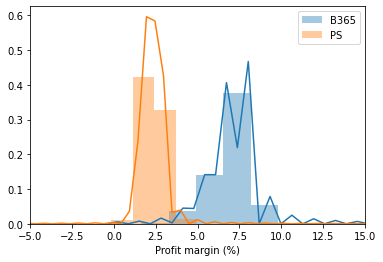

In [22]:
plt.figure
sns.distplot(100*matrix_j['B365_marg_prob'],bins = 50)
sns.distplot(100*matrix_j['PS_marg_prob'],bins = 50)
#sns.distplot(100*matrix_j['Avg_marg_prob'],bins = 50)
plt.xlim(-5,15)
plt.legend(['B365','PS'])
plt.xlabel('Profit margin (%)')

Looking at the distribution of the probability sum, it is apparent that the majority of the sum are slightly larger than zero, making profit for the bookmakers. It is also clear that B365 offers a more aggressive betting odds compared to PS (the probability sum is around three times of the PS!). So better not to go with B365 unless you want to donate more money to the bookmaker. 

It seems there are rare occassions where the probability sum calculated from odds become negative, it could be numerical errors or records errors, or the fact that the odds were adjusted based on the bias of sold tickets on the two players. 

In [24]:
cond = (matrix_j['B365_marg_prob']<0) | (matrix_j['PS_marg_prob']<0) 
matrix_j[cond][['B365_marg_prob','PS_marg_prob']]

,B365_marg_prob,PS_marg_prob
17726,0.075758,-0.104917
20208,0.084291,-0.232720
20694,0.081387,-0.076318
47798,0.077922,-0.001657
47807,0.081387,-0.018605
47840,0.048346,-0.004634
47864,0.068627,-0.082181
47868,0.057586,-0.009150


<a id='bs'></a>
 ##  4. [Betting Strategies](#Contents)

Below we introduce different betting strategies, and see how they perform

In [177]:
# define a dataframe to summarize the typical performance
summary = pd.DataFrame()

Assume we bet on matches since 2012.

(1) If we bet a constant amount of money on whoever has a lower betting odds, i.e. whoever is more likely to win the game, the profit rate we will have is  

In [178]:
cond = matrix_j.year>=2012
cond2 = matrix_j['B365_p2'].notnull()
cond3 = matrix_j['PS_p2'].notnull()

matrix_j['B365_revenue_1'] = (matrix_j['B365_p1']<matrix_j['B365_p2'])*(matrix_j['B365_p1']*matrix_j['p1_win']-1)\
                            +(matrix_j['B365_p1']>matrix_j['B365_p2'])*(matrix_j['B365_p2']*(1-matrix_j['p1_win'])-1)

matrix_j['PS_revenue_1'] = (matrix_j['PS_p1']<matrix_j['PS_p2'])*(matrix_j['PS_p1']*matrix_j['p1_win']-1)\
                            +(matrix_j['PS_p1']>matrix_j['PS_p2'])*(matrix_j['PS_p2']*(1-matrix_j['p1_win'])-1)

summary.loc[0,'Strategy_code'] = 'C1'
summary.loc[0,'Strategy'] = 'A constant bet on players with smaller odds'

APR_B365_ave = 100*matrix_j[cond&cond2]['B365_revenue_1'].sum()/matrix_j[cond&cond2]['B365_revenue_1'].notnull().count()
APR_PS_ave = 100*matrix_j[cond&cond2]['PS_revenue_1'].sum()/matrix_j[cond&cond2]['PS_revenue_1'].notnull().count()

#APR_B365_std = 100*matrix_j[cond&cond2]['B365_revenue_1'].std()
#APR_PS_std = 100*matrix_j[cond&cond3]['PS_revenue_1'].std()

summary.loc[0,'Ann.PR_ave_B365 (%)'] =  APR_B365_ave/8
summary.loc[0,'Ann.PR_ave_PS (%)'] =  APR_PS_ave/8
#summary.loc[0,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
#summary.loc[0,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary


,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%)
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669


(2) If we bet a constant amount of money on whoever has a higher betting odds, i.e. whoever is less likely to win the game, the profit rate we will have is  

In [179]:
matrix_j['B365_revenue_2'] = (matrix_j['B365_p1']>matrix_j['B365_p2'])*(matrix_j['B365_p1']*matrix_j['p1_win']-1)\
                            +(matrix_j['B365_p1']<matrix_j['B365_p2'])*(matrix_j['B365_p2']*(1-matrix_j['p1_win'])-1)

matrix_j['PS_revenue_2'] = (matrix_j['PS_p1']>matrix_j['PS_p2'])*(matrix_j['PS_p1']*matrix_j['p1_win']-1)\
                            +(matrix_j['PS_p1']<matrix_j['PS_p2'])*(matrix_j['PS_p2']*(1-matrix_j['p1_win'])-1)


summary.loc[1,'Strategy_code'] = 'C2'
summary.loc[1,'Strategy'] = 'A constant bet on players with larger odds'

APR_B365_ave = 100*matrix_j[cond&cond2]['B365_revenue_2'].sum()/matrix_j[cond&cond2]['B365_revenue_2'].notnull().count()
APR_PS_ave = 100*matrix_j[cond&cond2]['PS_revenue_2'].sum()/matrix_j[cond&cond2]['PS_revenue_2'].notnull().count()

#APR_B365_std = 100*matrix_j[cond&cond2]['B365_revenue_2'].std()
#APR_PS_std = 100*matrix_j[cond&cond3]['PS_revenue_2'].std()

summary.loc[1,'Ann.PR_ave_B365 (%)'] =  APR_B365_ave/8
summary.loc[1,'Ann.PR_ave_PS (%)'] =  APR_PS_ave/8
#summary.loc[1,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
#summary.loc[1,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary

,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%)
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003


(3) If we bet a constant amount of money on both side:

In [180]:
matrix_j['B365_revenue_3'] = matrix_j['p1_win']*matrix_j['B365_p1']+(1-matrix_j['p1_win'])*matrix_j['B365_p2']-2

matrix_j['PS_revenue_3'] = matrix_j['p1_win']*matrix_j['PS_p1']+(1-matrix_j['p1_win'])*matrix_j['PS_p2']-2

summary.loc[2,'Strategy_code'] = 'C3'
summary.loc[2,'Strategy'] = 'A constant bet on both sides'

APR_B365_ave = 100*matrix_j[cond&cond2]['B365_revenue_3'].sum()/matrix_j[cond&cond2]['B365_revenue_3'].notnull().count()/2
APR_PS_ave = 100*matrix_j[cond&cond2]['PS_revenue_3'].sum()/matrix_j[cond&cond2]['PS_revenue_3'].notnull().count()/2

#APR_B365_std = 100*matrix_j[cond&cond2]['B365_revenue_3'].std()
#APR_PS_std = 100*matrix_j[cond&cond3]['PS_revenue_3'].std()

summary.loc[2,'Ann.PR_ave_B365 (%)'] =  APR_B365_ave/8
summary.loc[2,'Ann.PR_ave_PS (%)'] =  APR_PS_ave/8
#summary.loc[1,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
#summary.loc[1,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary

,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%)
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003
2,C3,A constant bet on both sides,-0.970457,-0.414811


(4) More generally, if we bet an amount of $(O_2/O_1 + C)^S$ on p1 when $O_2/O_1 > 1$, $C$ and $S$ are real numbers

In [181]:

def revenue_S1(matrix_j,C,S,max_bet):
    
    invest = pd.DataFrame()
    
    profit = pd.DataFrame()
    
    cond1 = (matrix_j['B365_p1']>=0)&(matrix_j['B365_p2']>=0)&(matrix_j.year>=year_test)

    cond2 = (matrix_j['PS_p1']>=0)&(matrix_j['PS_p2']>=0)&(matrix_j.year>=year_test)

       
    invest['B365'] = (((matrix_j['B365_p2']/matrix_j['B365_p1']+C)**S).fillna(0)*(matrix_j['B365_p2']>matrix_j['B365_p1'])+\
    ((matrix_j['B365_p1']/matrix_j['B365_p2']+C)**S).fillna(0)*(matrix_j['B365_p1']>matrix_j['B365_p2']))
    
    invest['PS'] = (((matrix_j['PS_p2']/matrix_j['PS_p1']+C)**S).fillna(0)*(matrix_j['PS_p2']>matrix_j['PS_p1'])+\
    ((matrix_j['PS_p1']/matrix_j['PS_p2']+C)**S).fillna(0)*(matrix_j['PS_p1']>matrix_j['PS_p2']))
     
    # To avoid exploding investment, we set maximum bet as $max_bet, and minimal as $0, normalize the betting, if
    #some are smaller than $1, we will just ignore them
    
    norm_B365 = max_bet/max(invest['B365'][invest['B365']>0])
    norm_PS = max_bet/max(invest['PS'][invest['PS']>0])
    
    invest['B365'] = (norm_B365*invest['B365']).round()
    invest['PS'] = (norm_PS*invest['PS']).round()
    
     
    #profit
    profit['B365'] = (matrix_j['B365_p2']>matrix_j['B365_p1'])*(matrix_j['p1_win']*matrix_j['B365_p1']-1)+\
                    (matrix_j['B365_p2']<matrix_j['B365_p1'])*((1-matrix_j['p1_win'])*matrix_j['B365_p2']-1)
    
    profit['PS'] = (matrix_j['PS_p2']>matrix_j['PS_p1'])*(matrix_j['p1_win']*matrix_j['PS_p1']-1)+\
                    (matrix_j['PS_p2']<matrix_j['PS_p1'])*((1-matrix_j['p1_win'])*matrix_j['PS_p2']-1)    
    
    
    profit['B365'] = profit['B365'] * invest['B365']
    profit['PS'] = profit['PS'] *invest['PS']
    
    # total investment
    total_invest_B365 = invest['B365'][cond1].sum()  
    total_invest_PS = invest['PS'][cond2].sum()
    
    # total profit
    total_prf_B365 = profit['B365'][cond1].sum()  
    total_prf_PS = profit['PS'][cond2].sum() 
    
    #profit rate
    PR_B365 = 100*total_prf_B365/total_invest_B365 
    PR_PS = 100*total_prf_PS/total_invest_PS
    
    if total_invest_B365 == 0: 
        PR_B365 = 0
        
    if total_invest_PS == 0: 
        PR_PS = 0
    
    
    matrix_com = matrix_j[['year','p1_win','p1_win_pred','B365_p1','B365_p2','PS_p1','PS_p2']]
    matrix_com[['invest_B365','invest_PS']]= invest
    matrix_com[['profit_B365','profit_PS']]= profit
    
    return PR_B365,PR_PS,total_invest_B365,total_invest_PS, total_prf_B365,total_prf_PS,invest,profit,matrix_com


In [25]:
PR_B365,PR_PS,total_invest_B365,total_invest_PS,total_prf_B365,total_prf_PS,_,_,matrix_com = revenue_S(matrix_j,C=0,S=-2,max_bet=5000)
matrix_com

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,p1_win,p1_win_pred,B365_p1,B365_p2,PS_p1,PS_p2,invest_B365,invest_PS,profit_B365,profit_PS
27473,0.0,0.200243,6.00,1.10,5.91,1.18,187.0,203.0,18.70,36.54
27491,1.0,0.665293,2.10,1.66,2.31,1.70,3471.0,2764.0,-3471.00,-2764.00
27508,1.0,0.251076,2.62,1.44,2.54,1.60,1678.0,2025.0,-1678.00,-2025.00
27511,1.0,0.653954,1.22,4.00,1.35,3.63,517.0,706.0,113.74,247.10
27512,0.0,0.366477,2.62,1.44,2.90,1.48,1678.0,1329.0,738.32,637.92
...,...,...,...,...,...,...,...,...,...,...
49054,0.0,0.214055,4.50,1.18,5.04,1.21,382.0,294.0,68.76,61.74
49055,1.0,0.573734,1.50,2.50,1.48,2.88,2000.0,1348.0,1000.00,647.04
49056,0.0,0.666503,1.20,4.33,1.21,5.05,427.0,293.0,-427.00,-293.00
49057,0.0,0.336532,2.75,1.44,2.69,1.54,1523.0,1673.0,670.12,903.42


In [21]:

def revenue_scan(matrix_j,S_range,C_range,max_bet,model = 'S'):

    PR_B365 = np.zeros((len(S_range),len(C_range)),dtype=np.float64)
    PR_PS = np.zeros((len(S_range),len(C_range)),dtype=np.float64)
    inv_B365 = np.zeros((len(S_range),len(C_range)),dtype=np.float64)
    inv_PS = np.zeros((len(S_range),len(C_range)),dtype=np.float64)
    prf_B365 = np.zeros((len(S_range),len(C_range)),dtype=np.float64)
    prf_PS = np.zeros((len(S_range),len(C_range)),dtype=np.float64)

    j = 0

    for C in C_range:
        i=0
        for S in S_range:

            if model == 'S1':                
                PR_B365[i,j], PR_PS[i,j],inv_B365[i,j],inv_PS[i,j],prf_B365[i,j],prf_PS[i,j],_,_,_ = revenue_S1(matrix_j,C,S,max_bet=max_bet)
            elif model == 'S2':
                PR_B365[i,j], PR_PS[i,j],inv_B365[i,j],inv_PS[i,j],prf_B365[i,j],prf_PS[i,j],_,_,_ = revenue_S2(matrix_j,C,S,max_bet=max_bet)
          
            elif model == 'SM1': 
                PR_B365[i,j], PR_PS[i,j],inv_B365[i,j],inv_PS[i,j],prf_B365[i,j],prf_PS[i,j],_,_,_ = revenue_SM1(matrix_j,C,S,max_bet=max_bet)
            elif model == 'SM2': 
                PR_B365[i,j], PR_PS[i,j],inv_B365[i,j],inv_PS[i,j],prf_B365[i,j],prf_PS[i,j],_,_,_ = revenue_SM2(matrix_j,C,S,max_bet=max_bet)
            elif model == 'SM3': 
                #print(model)
                PR_B365[i,j], PR_PS[i,j],inv_B365[i,j],inv_PS[i,j],prf_B365[i,j],prf_PS[i,j],_,_,_ = revenue_SM3(matrix_j,C,S,max_bet=max_bet)
            elif model == 'SM4': 
                #print(model)
                PR_B365[i,j], PR_PS[i,j],inv_B365[i,j],inv_PS[i,j],prf_B365[i,j],prf_PS[i,j],_,_,_ = revenue_SM4(matrix_j,C,S,max_bet=max_bet)
            
            i+=1

        j+=1
        
    return PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS



In [19]:
def plot_revenue(S_range,C_range,PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS):
    
    x,y = np.meshgrid(S_range,C_range)
    plt.figure(figsize = (10,8))
    plt.subplot(3,2,1)
    plt.contour(x,y, PR_B365.T,21,cmap='PiYG',vmin = -min(abs(PR_B365.min()),abs(PR_B365.max())), vmax = min(abs(PR_B365.min()),abs(PR_B365.max()))) 
    plt.colorbar()
    plt.title('Profit ratio (%) - B365')
    plt.xlabel('S')
    plt.ylabel('C')

    plt.subplot(3,2,2)
    plt.contour(x,y, PR_PS.T,21,cmap='PiYG',vmin = -min(abs(PR_PS.min()),abs(PR_PS.max())), vmax = min(abs(PR_PS.min()),abs(PR_PS.max())))
    plt.colorbar()
    plt.title('Profit ratio (%) - PS')
    plt.xlabel('S')
    plt.ylabel('C')

    plt.subplot(3,2,3)
    plt.contour(x,y, np.log10(inv_B365.T),50,cmap='viridis',vmin = 0, vmax = 6.5)
    plt.colorbar()
    plt.title('Total investment log10($) - B365')
    plt.xlabel('S')
    plt.ylabel('C')

    plt.subplot(3,2,4)
    plt.contour(x,y, np.log10(inv_PS.T),50,cmap='viridis',vmin = 0, vmax = 6.5)
    plt.colorbar()
    plt.title('Total investment log10($) - PS')
    plt.xlabel('S')
    plt.ylabel('C')

    plt.subplot(3,2,5)
    
    if (prf_B365>0).sum()>0:
        plt.contour(x,y, np.log10(prf_B365.T),50,cmap='viridis',vmin = 0, vmax = 5)
        plt.colorbar()
    plt.title('Total profit log10($) - B365')
    plt.xlabel('S')
    plt.ylabel('C')

    plt.subplot(3,2,6)
    
    if (prf_PS>0).sum()>0:
        plt.contour(x,y, np.log10(prf_PS.T),50,cmap='viridis',vmin = 0, vmax = 5)
        plt.colorbar()        
    
    plt.title('Total profit log10($) - PS')
    plt.xlabel('S')
    plt.ylabel('C')

    plt.tight_layout()
    
    return 



We have look how the betting performance look like for betting model 'S'

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10


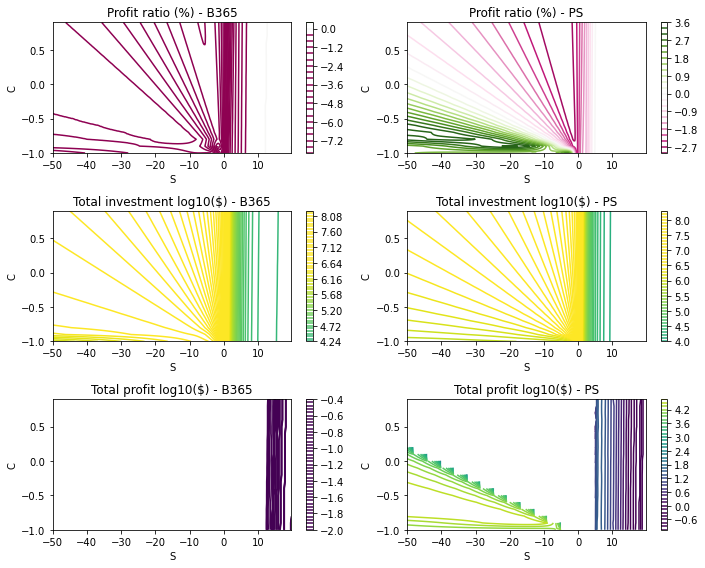

In [305]:
S_range = np.arange(-50,20,0.25)
C_range = np.arange(-1,1,0.1)
max_bet = 10000

PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS = revenue_scan(matrix_j,S_range,C_range,max_bet, model = 'S')

plot_revenue(S_range,C_range,PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS)

It is surprised to see that it is possible to get a noticeable positive profit using bookmaker PS. It is also surprised that the parameter regime for positive profit is when both C and S are smaller than zero.

In [182]:
# record a typical profit rate
n = 3
C = -0.85
S = -20
pr_B365, pr_PS,inv_B365,inv_PS,prf_B365,prf_PS,_,_,_ = revenue_S1(matrix_j,C = C,S=S,max_bet=max_bet)
            
summary.loc[n,'Strategy_code'] = 'S1'
summary.loc[n,'Strategy'] = 'Bet (O_2/O_1 + C)^S on p1 when O_2/O_1 > 1'
summary.loc[n,'C'] = C
summary.loc[n,'S'] = S

summary.loc[n,'Ann.PR_ave_B365 (%)'] =  pr_B365/8
summary.loc[n,'Ann.PR_ave_PS (%)'] =  pr_PS/8
# summary.loc[n,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
# summary.loc[n,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%),C,S
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669,NaN,NaN
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003,NaN,NaN
2,C3,A constant bet on both sides,-0.970457,-0.414811,NaN,NaN
3,S1,Bet (O_2/O_1 + C)^S on p1 when O_2/O_1 > 1,-0.609065,0.614508,-0.85,-20.0


(5) Apart from the betting odds provided by the bookmakers, we now take into account the winning propabilities provided by our ML models. We only invest in games where both the bookmakers and ML models have the same prediction for winners.

In [137]:
def revenue_SM1(matrix_j,C,S,max_bet):
    
    invest = pd.DataFrame()
    
    profit = pd.DataFrame()
    
    cond1 = (((matrix_j['p1_win_pred']>0.5)&(matrix_j['B365_pred']==1))|
        ((matrix_j['p1_win_pred']<0.5)&(matrix_j['B365_pred']==0)))&(matrix_j.year>=year_test)
    
    cond2 = (((matrix_j['p1_win_pred']>0.5)&(matrix_j['PS_pred']==1))|
        ((matrix_j['p1_win_pred']<0.5)&(matrix_j['PS_pred']==0)))&(matrix_j.year>=year_test)


    invest['B365'] = (((matrix_j['B365_p2']/matrix_j['B365_p1']+C)**S).fillna(0)*((matrix_j['B365_p2']>matrix_j['B365_p1'])&(matrix_j['p1_win_pred']>0.5))+\
    ((matrix_j['B365_p1']/matrix_j['B365_p2']+C)**S).fillna(0)*((matrix_j['B365_p1']>matrix_j['B365_p2'])&(matrix_j['p1_win_pred']<0.5)))
    
    invest['PS'] = (((matrix_j['PS_p2']/matrix_j['PS_p1']+C)**S).fillna(0)*((matrix_j['PS_p2']>matrix_j['PS_p1'])&(matrix_j['p1_win_pred']>0.5))+\
    ((matrix_j['PS_p1']/matrix_j['PS_p2']+C)**S).fillna(0)*((matrix_j['PS_p1']>matrix_j['PS_p2'])&(matrix_j['p1_win_pred']<0.5)))
     
    # To avoid exploding investment, we set maximum bet as $max_bet, and minimal as $0, normalize the betting, if
    #some are smaller than $1, we will just ignore them
    
    norm_B365 = max_bet/max(invest['B365'][invest['B365']>0])
    norm_PS = max_bet/max(invest['PS'][invest['PS']>0])
    
    invest['B365'] = (norm_B365*invest['B365']).round()
    invest['PS'] = (norm_PS*invest['PS']).round()
    
     
    #profit
    profit['B365'] = ((matrix_j['B365_p2']>matrix_j['B365_p1'])&(matrix_j['p1_win_pred']>0.5))*(matrix_j['p1_win']*matrix_j['B365_p1']-1)+\
                    ((matrix_j['B365_p2']<matrix_j['B365_p1'])&(matrix_j['p1_win_pred']<0.5))*((1-matrix_j['p1_win'])*matrix_j['B365_p2']-1)
    
    profit['PS'] = ((matrix_j['PS_p2']>matrix_j['PS_p1'])&(matrix_j['p1_win_pred']>0.5))*(matrix_j['p1_win']*matrix_j['PS_p1']-1)+\
                    ((matrix_j['PS_p2']<matrix_j['PS_p1'])&(matrix_j['p1_win_pred']<0.5))*((1-matrix_j['p1_win'])*matrix_j['PS_p2']-1)    
    
    
    profit['B365'] = profit['B365'] * invest['B365']
    profit['PS'] = profit['PS'] *invest['PS']
    
    # total investment
    total_invest_B365 = invest['B365'][cond1].sum()  
    total_invest_PS = invest['PS'][cond2].sum()
    
    # total profit
    total_prf_B365 = profit['B365'][cond1].sum()  
    total_prf_PS = profit['PS'][cond2].sum() 
    
    #profit rate
    PR_B365 = 100*total_prf_B365/total_invest_B365 
    PR_PS = 100*total_prf_PS/total_invest_PS
    
    if total_invest_B365 == 0: 
        PR_B365 = 0
        
    if total_invest_PS == 0: 
        PR_PS = 0
    
    
    matrix_com = matrix_j[['year','p1_win','p1_win_pred','B365_p1','B365_p2','PS_p1','PS_p2']]
    matrix_com[['invest_B365','invest_PS']]= invest
    matrix_com[['profit_B365','profit_PS']]= profit
    
    return PR_B365,PR_PS,total_invest_B365,total_invest_PS, total_prf_B365,total_prf_PS,invest,profit,matrix_com

Let's have look how the betting performance looks like for betting model 'SM1'

In [308]:
S_range = np.arange(-50,20,0.25)
C_range = np.arange(-1,1,0.1)
max_bet = 10000

PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS = revenue_scan(matrix_j,S_range,C_range,max_bet, model = 'SM1')

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10


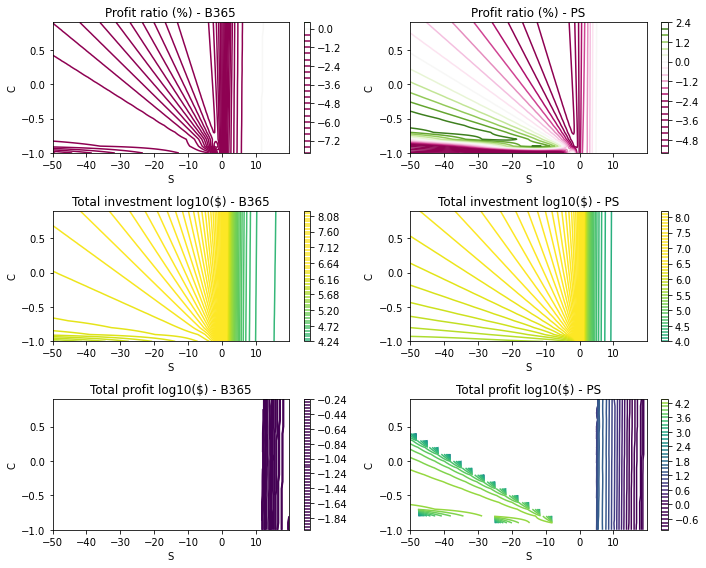

In [310]:
plot_revenue(S_range,C_range,PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS)

In [183]:
# record a typical profit rate
n = 5
C = -0.85
S = -20
pr_B365, pr_PS,inv_B365,inv_PS,prf_B365,prf_PS,_,_,_ = revenue_SM1(matrix_j,C = C,S=S,max_bet=max_bet)
            
summary.loc[n,'Strategy_code'] = 'SM1'
summary.loc[n,'Strategy'] = 'Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1>p_2'
summary.loc[n,'C'] = C
summary.loc[n,'S'] = S

summary.loc[n,'Ann.PR_ave_B365 (%)'] =  pr_B365/8
summary.loc[n,'Ann.PR_ave_PS (%)'] =  pr_PS/8
# summary.loc[n,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
# summary.loc[n,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%),C,S
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669,NaN,NaN
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003,NaN,NaN
2,C3,A constant bet on both sides,-0.970457,-0.414811,NaN,NaN
3,S1,Bet (O_2/O_1 + C)^S on p1 when O_2/O_1 > 1,-0.609065,0.614508,-0.85,-20.0
5,SM1,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1>p_2,-0.482294,0.553304,-0.85,-20.0


After considering the result from both machine learning model and bookmakers, the maximal positive profit rate is lower. This could be the fact that when both machine learning model and bookmakers give the same prediction, the result of the game is more certain, and the bookmakers set a betting odds that is more favourable to them.

If that is the case, we can try the other way around, only choose those matches where the bookmakers and machine learning model do not agree on.

In [129]:
def revenue_SM2(matrix_j,C,S,max_bet):
    
    invest = pd.DataFrame()
    
    profit = pd.DataFrame()
            
    cond1 = (matrix_j['B365_p1']>=0)&(matrix_j['B365_p2']>=0)&(matrix_j.year>=year_test)

    cond2 = (matrix_j['PS_p1']>=0)&(matrix_j['PS_p2']>=0)&(matrix_j.year>=year_test)    
       
    invest['B365_1'] = (((matrix_j['B365_p2']>matrix_j['B365_p1'])&(matrix_j['p1_win_pred']<matrix_j['p2_win_pred']))*\
                        (matrix_j['p2_win_pred']/matrix_j['p1_win_pred']+matrix_j['B365_p2']/matrix_j['B365_p1']+C)**S).fillna(0)
    
    invest['B365_2'] = (((matrix_j['B365_p1']>matrix_j['B365_p2'])&(matrix_j['p2_win_pred']<matrix_j['p1_win_pred']))*\
                        (matrix_j['p1_win_pred']/matrix_j['p2_win_pred']+matrix_j['B365_p1']/matrix_j['B365_p2']+C)**S).fillna(0)    
    
    invest['PS_1'] =(((matrix_j['PS_p2']>matrix_j['PS_p1'])&(matrix_j['p1_win_pred']<matrix_j['p2_win_pred']))*\
                        (matrix_j['p2_win_pred']/matrix_j['p1_win_pred']+matrix_j['PS_p2']/matrix_j['PS_p1']+C)**S).fillna(0)
    
    invest['PS_2'] = (((matrix_j['PS_p1']>matrix_j['PS_p2'])&(matrix_j['p2_win_pred']<matrix_j['p1_win_pred']))*\
                        (matrix_j['p1_win_pred']/matrix_j['p2_win_pred']+matrix_j['PS_p1']/matrix_j['PS_p2']+C)**S).fillna(0)
         
    # To avoid exploding investment, we set maximum bet as $max_bet, and minimal as $0, normalize the betting, if
    #some are smaller than $1, we will just ignore them
    invest['B365'] = invest['B365_1'] + invest['B365_2']
    invest['PS'] = invest['PS_1'] + invest['PS_2']
    
    norm_B365 = max_bet/max(invest['B365'][invest['B365']>0])
    norm_PS = max_bet/max(invest['PS'][invest['PS']>0])
    
    invest['B365'] = (norm_B365*invest['B365']).round()
    invest['PS'] = (norm_PS*invest['PS']).round()    
     
    #profit 
    profit['B365'] = norm_B365*((matrix_j['p1_win']*matrix_j['B365_p1']-1)*invest['B365_1']+\
                    ((1-matrix_j['p1_win'])*matrix_j['B365_p2']-1)*invest['B365_2'])
    
    profit['PS'] = norm_PS*((matrix_j['p1_win']*matrix_j['PS_p1']-1)*invest['PS_1']+\
                    ((1-matrix_j['p1_win'])*matrix_j['PS_p2']-1)*invest['PS_2'])    
     
    # total investment
    total_invest_B365 = invest['B365'][cond1].sum()  
    total_invest_PS = invest['PS'][cond2].sum()
    
    # total profit
    total_prf_B365 = profit['B365'][cond1].sum()  
    total_prf_PS = profit['PS'][cond2].sum() 
    
    #profit rate
    PR_B365 = 100*total_prf_B365/total_invest_B365 
    PR_PS = 100*total_prf_PS/total_invest_PS
    
    if total_invest_B365 == 0: 
        PR_B365 = 0
        
    if total_invest_PS == 0: 
        PR_PS = 0
    
    
    matrix_com = matrix_j[['year','p1_win','p1_win_pred','B365_p1','B365_p2','PS_p1','PS_p2']]
    matrix_com[['invest_B365','invest_PS']]= invest[['B365','PS']]
    matrix_com[['profit_B365','profit_PS']]= profit
    
    return PR_B365,PR_PS,total_invest_B365,total_invest_PS, total_prf_B365,total_prf_PS,invest,profit,matrix_com

In [292]:
S_range = np.arange(-50,20,0.25)
C_range = np.arange(-1,1,0.1)
max_bet = 10000

PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS = revenue_scan(matrix_j,S_range,C_range,max_bet, model = 'SM2')


C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10


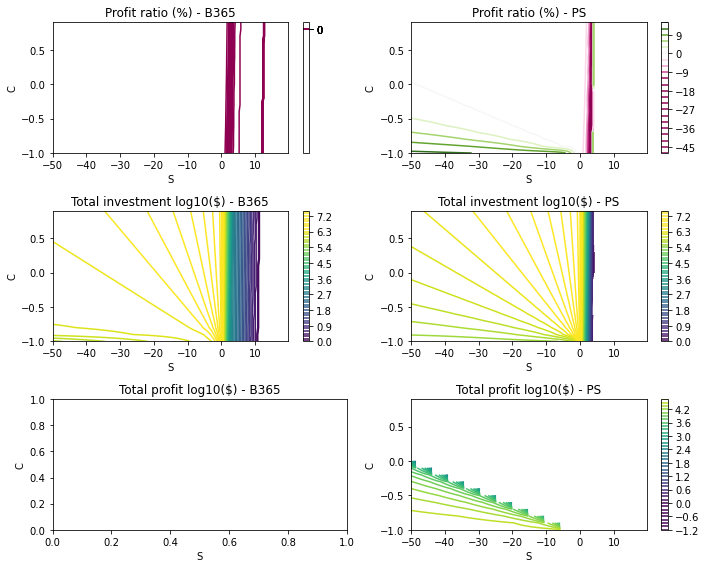

In [330]:
plot_revenue(S_range,C_range,PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS)

There is no significant change in the total profit from bookmakers PS when using the difference set compared to using the full data set, but the profit ratio is higher. On the other hand, when using the difference set, the profit becomes all negative in the whole parametric space of B365. It seems that the two book makers have different strategies in the betting odds when it comes to highly uncertain games.

In [184]:
# record a typical profit rate
n = 6
C = -1
S = -40
pr_B365, pr_PS,inv_B365,inv_PS,prf_B365,prf_PS,_,_,_ = revenue_SM2(matrix_j,C = C,S=S,max_bet=max_bet)
            
summary.loc[n,'Strategy_code'] = 'SM2'
summary.loc[n,'Strategy'] = 'Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1<p_2'
summary.loc[n,'C'] = C
summary.loc[n,'S'] = S

summary.loc[n,'Ann.PR_ave_B365 (%)'] =  pr_B365/8
summary.loc[n,'Ann.PR_ave_PS (%)'] =  pr_PS/8
# summary.loc[n,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
# summary.loc[n,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%),C,S
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669,NaN,NaN
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003,NaN,NaN
2,C3,A constant bet on both sides,-0.970457,-0.414811,NaN,NaN
3,S1,Bet (O_2/O_1 + C)^S on p1 when O_2/O_1 > 1,-0.609065,0.614508,-0.85,-20.0
5,SM1,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1>p_2,-0.482294,0.553304,-0.85,-20.0
6,SM2,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1<p_2,0.962800,2.877291,-1.00,-40.0


(6) If now we bet on both p1 or p2, with $M_1/M_2 = (O_2/O_1+C)^S, M2 = 1$, if $M_1/M_2 > 1$

In [366]:
def revenue_S2(matrix_j,C,S,max_bet):
    
    invest = pd.DataFrame()
    
    profit = pd.DataFrame()
    
    cond1 = (matrix_j['B365_p1']>=0)&(matrix_j['B365_p2']>=0)&(matrix_j.year>=year_test)

    cond2 = (matrix_j['PS_p1']>=0)&(matrix_j['PS_p2']>=0)&(matrix_j.year>=year_test)
    
       
    invest['B365_1'] = ((matrix_j['B365_p2']>matrix_j['B365_p1'])*((matrix_j['B365_p2']/matrix_j['B365_p1']+C)**S)+\
                    (matrix_j['B365_p2']<matrix_j['B365_p1'])*(1)).fillna(0)
    
    invest['B365_2'] = ((matrix_j['B365_p2']>matrix_j['B365_p1'])*(1)+\
                    (matrix_j['B365_p2']<matrix_j['B365_p1'])*((matrix_j['B365_p1']/matrix_j['B365_p2']+C)**(S))).fillna(0)
    
    invest['PS_1'] = ((matrix_j['PS_p2']>matrix_j['PS_p1'])*((matrix_j['PS_p2']/matrix_j['PS_p1']+C)**S)+\
                    (matrix_j['PS_p2']<matrix_j['PS_p1'])*(1)).fillna(0)
    
    invest['PS_2'] =((matrix_j['PS_p2']>matrix_j['PS_p1'])*(1)+\
                    (matrix_j['PS_p2']<matrix_j['PS_p1'])*((matrix_j['PS_p1']/matrix_j['PS_p2']+C)**(S))).fillna(0)
         
    # To avoid exploding investment, we set maximum bet as $max_bet, and minimal as $0, normalize the betting, if
    #some are smaller than $1, we will just ignore them
    invest['B365'] = invest['B365_1'] + invest['B365_2']
    invest['PS'] = invest['PS_1'] + invest['PS_2']
    
    norm_B365 = max_bet/max(invest['B365'][invest['B365']>0])
    norm_PS = max_bet/max(invest['PS'][invest['PS']>0])
    
    invest['B365'] = (norm_B365*invest['B365']).round()
    invest['PS'] = (norm_PS*invest['PS']).round()    
     
    #profit 
    profit['B365'] = norm_B365*((matrix_j['p1_win']*matrix_j['B365_p1']-1)*invest['B365_1']+\
                    ((1-matrix_j['p1_win'])*matrix_j['B365_p2']-1)*invest['B365_2'])
    
    profit['PS'] = norm_PS*((matrix_j['p1_win']*matrix_j['PS_p1']-1)*invest['PS_1']+\
                    ((1-matrix_j['p1_win'])*matrix_j['PS_p2']-1)*invest['PS_2'])  
        
    # total investment
    total_invest_B365 = invest['B365'][cond1].sum()  
    total_invest_PS = invest['PS'][cond2].sum()
    
    # total profit
    total_prf_B365 = profit['B365'][cond1].sum()  
    total_prf_PS = profit['PS'][cond2].sum() 
    
    #profit rate
    PR_B365 = 100*total_prf_B365/total_invest_B365 
    PR_PS = 100*total_prf_PS/total_invest_PS
    
    if total_invest_B365 == 0: 
        PR_B365 = 0
        
    if total_invest_PS == 0: 
        PR_PS = 0
    
    
    matrix_com = matrix_j[['year','p1_win','p1_win_pred','B365_p1','B365_p2','PS_p1','PS_p2']]
    matrix_com[['invest_B365','invest_PS']]= invest[['B365','PS']]
    matrix_com[['profit_B365','profit_PS']]= profit[['B365','PS']]
    
    return PR_B365,PR_PS,total_invest_B365,total_invest_PS, total_prf_B365,total_prf_PS,invest,profit,matrix_com

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10


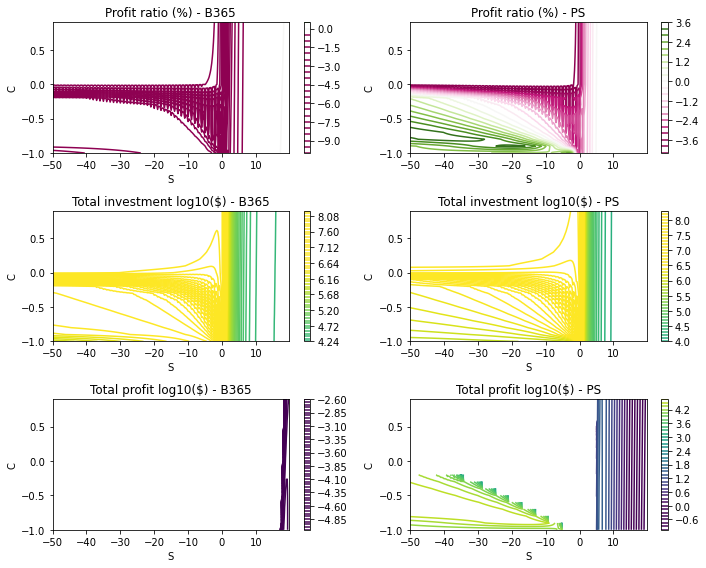

In [367]:
S_range = np.arange(-50,20,0.25)
C_range = np.arange(-1,1,0.1)
max_bet = 10000

PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS = revenue_scan(matrix_j,S_range,C_range,max_bet, model = 'S2')
plot_revenue(S_range,C_range,PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS)

The regime for positive return becomes smaller

In [185]:
# record a typical profit rate
n = 4
C = -0.85
S = -20
pr_B365, pr_PS,inv_B365,inv_PS,prf_B365,prf_PS,_,_,_ = revenue_S1(matrix_j,C = C,S=S,max_bet=max_bet)
            
summary.loc[n,'Strategy_code'] = 'S2'
summary.loc[n,'Strategy'] = 'Bet (O_2/O_1 + C)^S on p1, and 1 on p2 when O_2/O_1 > 1'
summary.loc[n,'C'] = C
summary.loc[n,'S'] = S

summary.loc[n,'Ann.PR_ave_B365 (%)'] =  pr_B365/8
summary.loc[n,'Ann.PR_ave_PS (%)'] =  pr_PS/8
# summary.loc[n,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
# summary.loc[n,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%),C,S
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669,NaN,NaN
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003,NaN,NaN
2,C3,A constant bet on both sides,-0.970457,-0.414811,NaN,NaN
3,S1,Bet (O_2/O_1 + C)^S on p1 when O_2/O_1 > 1,-0.609065,0.614508,-0.85,-20.0
5,SM1,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1>p_2,-0.482294,0.553304,-0.85,-20.0
6,SM2,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1<p_2,0.962800,2.877291,-1.00,-40.0
4,S2,"Bet (O_2/O_1 + C)^S on p1, and 1 on p2 when O_...",-0.609065,0.614508,-0.85,-20.0


(6) If we bet on p1 with $(O_2/O_1+p_1/p_2+C)^S$ if the bookmakers and the ML model have the same prediction of winner

In [149]:
def revenue_SM3(matrix_j,C,S,max_bet):
    
    invest = pd.DataFrame()
    
    profit = pd.DataFrame()
    
    cond1 = (matrix_j['B365_p1']>=0)&(matrix_j['B365_p2']>=0)&(matrix_j.year>=year_test)

    cond2 = (matrix_j['PS_p1']>=0)&(matrix_j['PS_p2']>=0)&(matrix_j.year>=year_test)    
       
    invest['B365_1'] = (((matrix_j['B365_p2']>matrix_j['B365_p1'])&(matrix_j['p1_win_pred']>matrix_j['p2_win_pred']))*\
                        (matrix_j['p1_win_pred']/matrix_j['p2_win_pred']+matrix_j['B365_p2']/matrix_j['B365_p1']+C)**S).fillna(0)
    
    invest['B365_2'] = (((matrix_j['B365_p1']>matrix_j['B365_p2'])&(matrix_j['p2_win_pred']>matrix_j['p1_win_pred']))*\
                        (matrix_j['p2_win_pred']/matrix_j['p1_win_pred']+matrix_j['B365_p1']/matrix_j['B365_p2']+C)**S).fillna(0)    
    
    invest['PS_1'] =(((matrix_j['PS_p2']>matrix_j['PS_p1'])&(matrix_j['p1_win_pred']>matrix_j['p2_win_pred']))*\
                        (matrix_j['p1_win_pred']/matrix_j['p2_win_pred']+matrix_j['PS_p2']/matrix_j['PS_p1']+C)**S).fillna(0)
    
    invest['PS_2'] = (((matrix_j['PS_p1']>matrix_j['PS_p2'])&(matrix_j['p2_win_pred']>matrix_j['p1_win_pred']))*\
                        (matrix_j['p2_win_pred']/matrix_j['p1_win_pred']+matrix_j['PS_p1']/matrix_j['PS_p2']+C)**S).fillna(0)
         
    # To avoid exploding investment, we set maximum bet as $max_bet, and minimal as $0, normalize the betting, if
    #some are smaller than $1, we will just ignore them
    invest['B365'] = invest['B365_1'] + invest['B365_2']
    invest['PS'] = invest['PS_1'] + invest['PS_2']
    
    norm_B365 = max_bet/max(invest['B365'][invest['B365']>0])
    norm_PS = max_bet/max(invest['PS'][invest['PS']>0])
    
    invest['B365'] = (norm_B365*invest['B365']).round()
    invest['PS'] = (norm_PS*invest['PS']).round()    
     
    #profit 
    profit['B365'] = norm_B365*((matrix_j['p1_win']*matrix_j['B365_p1']-1)*invest['B365_1']+\
                    ((1-matrix_j['p1_win'])*matrix_j['B365_p2']-1)*invest['B365_2'])
    
    profit['PS'] = norm_PS*((matrix_j['p1_win']*matrix_j['PS_p1']-1)*invest['PS_1']+\
                    ((1-matrix_j['p1_win'])*matrix_j['PS_p2']-1)*invest['PS_2'])  
        
    # total investment
    total_invest_B365 = invest['B365'][cond1].sum()  
    total_invest_PS = invest['PS'][cond2].sum()
    
    # total profit
    total_prf_B365 = profit['B365'][cond1].sum()  
    total_prf_PS = profit['PS'][cond2].sum() 
    
    #profit rate
    PR_B365 = 100*total_prf_B365/total_invest_B365 
    PR_PS = 100*total_prf_PS/total_invest_PS
    
    if total_invest_B365 == 0: 
        PR_B365 = 0
        
    if total_invest_PS == 0: 
        PR_PS = 0
    
    
    matrix_com = matrix_j[['year','p1_win','p1_win_pred','B365_p1','B365_p2','PS_p1','PS_p2']]
    matrix_com[['invest_B365','invest_PS']]= invest[['B365','PS']]
    matrix_com[['profit_B365','profit_PS']]= profit[['B365','PS']]
    
    return PR_B365,PR_PS,total_invest_B365,total_invest_PS, total_prf_B365,total_prf_PS,invest,profit,matrix_com

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10


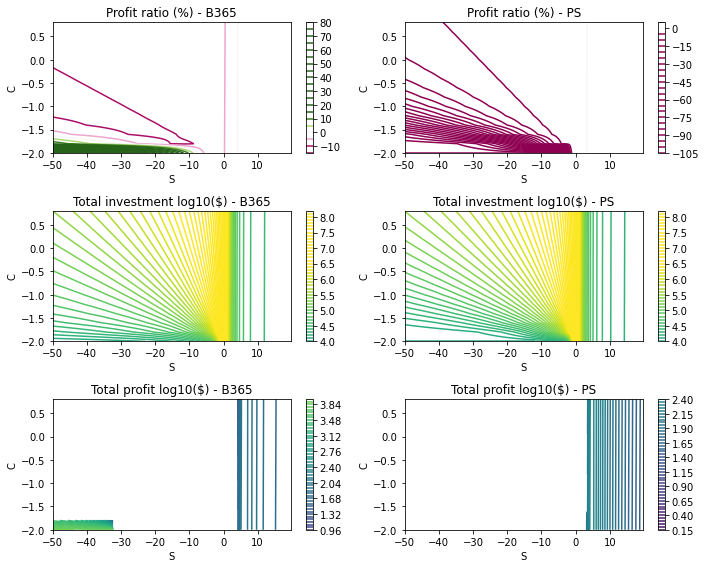

In [283]:
S_range = np.arange(-50,20,0.25)
C_range = np.arange(-2,1,0.2)
max_bet = 10000
year_test = 2012

PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS = revenue_scan(matrix_j,S_range,C_range,max_bet, model = 'SM3')
plot_revenue(S_range,C_range,PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS)

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:xlabel='p1_win_pred'>

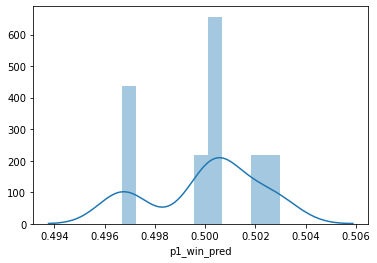

In [31]:
S  = -35
C  = -2
max_bet = 10000

PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_SM3(matrix_j,C,S,max_bet)
plt.figure
sns.distplot(matrix_com[matrix_com.invest_B365>0]['p1_win_pred'],bins= 11)

This betting strategy also show positive return for games where the predicted winning probabilities of the player is around 50%

In [159]:
# record a typical profit rate
n = 7
C = -2
S = -40
pr_B365, pr_PS,inv_B365,inv_PS,prf_B365,prf_PS,_,_,matrix_com = revenue_SM3(matrix_j,C = C,S=S,max_bet=max_bet)
            
summary.loc[n,'Strategy_code'] = 'SM3'
summary.loc[n,'Strategy'] = 'Bet (O_2/O_1 +p_1/P_2+ C)^S on p1 when O_2>O_1 & p_1<p_2'
summary.loc[n,'C'] = C
summary.loc[n,'S'] = S

summary.loc[n,'Ann.PR_ave_B365 (%)'] =  pr_B365/8
summary.loc[n,'Ann.PR_ave_PS (%)'] =  pr_PS/8
# summary.loc[n,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
# summary.loc[n,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%),C,S
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669,NaN,NaN
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003,NaN,NaN
2,C3,A constant bet on both sides,-0.970457,-0.414811,NaN,NaN
3,S1,Bet (O_2/O_1 + C)^S on p1 when O_2/O_1 > 1,-0.609065,0.614508,-0.85,-20.0
4,S2,"Bet (O_2/O_1 + C)^S on p1, and 1 on p2 when O_...",-0.609065,0.614508,-0.85,-20.0
5,SM1,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1>p_2,-0.482294,0.553304,-0.85,-20.0
6,SM2,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1<p_2,0.962800,2.877291,-1.00,-40.0
7,SM3,Bet (O_2/O_1 +p_1/P_2+ C)^S on p1 when O_2>O_1...,8.847204,-12.500000,-2.00,-40.0


In [160]:
matrix_com[matrix_com.invest_B365>0]

,year,p1_win,p1_win_pred,B365_p1,B365_p2,PS_p1,PS_p2,invest_B365,invest_PS,profit_B365,profit_PS
129,2010,1.0,0.500672,1.80,1.90,1.952,1.971,1.0,1.0,0.491375,9.182753e-01
752,2010,0.0,0.500356,1.80,1.90,1.901,2.030,1.0,0.0,-1.477051,-1.346241e-30
5644,2012,0.0,0.499933,1.95,1.85,2.040,1.880,10.0,0.0,8.500000,2.794419e-34
10738,2014,0.0,0.500624,1.80,1.90,2.030,1.880,1.0,0.0,-0.701329,0.000000e+00


It turns out that only 4 games were bet on.

(7) In general, the betting odds provided by the bookmakers is lower than the inverse propability $1/p_b$ from their models. 

It will be favoured to the betors if we only bet on those matches where our model shows a higher probability than the bookmakers, i.e.

if $1/O_{i} > 1/O_{j}$ and $p_{i} > 1/O_{i}$. We set the betting odd to $(p_{i}\times O_{i} + C)^S$

This idea is similar to one of the betting strategies in 'Exploiting sports-betting market using machine learning' 
http://ida.felk.cvut.cz/zelezny/pubs/ijf.2019.pdf

In [29]:
matrix_j['p2_win_pred'] = 1- matrix_j['p1_win_pred']

In [162]:
def revenue_SM4(matrix_j,C,S,max_bet):
    
    #print(C,S)
    invest = pd.DataFrame()
    
    profit = pd.DataFrame()
    
    cond1 = (matrix_j['B365_p1']>=0)&(matrix_j['B365_p2']>=0)&(matrix_j.year>=year_test)

    cond2 = (matrix_j['PS_p1']>=0)&(matrix_j['PS_p2']>=0)&(matrix_j.year>=year_test)
    
    #matrix_j['p2_win_pred'] = 1- matrix_j['p1_win_pred']
    
    # we bet an amount proportional to the relative difference   
    invest['B365_1'] = (((matrix_j['B365_p2']>matrix_j['B365_p1'])&(matrix_j['p1_win_pred']>1/matrix_j['B365_p1']))*\
                        (matrix_j['p1_win_pred']*matrix_j['B365_p1']+C)**S).fillna(0)
    
    invest['B365_2'] = (((matrix_j['B365_p1']>matrix_j['B365_p2'])&(matrix_j['p2_win_pred']>1/matrix_j['B365_p2']))*\
                        (matrix_j['p2_win_pred']*matrix_j['B365_p2']+C)**S).fillna(0)    
    
    invest['PS_1'] =(((matrix_j['PS_p2']>matrix_j['PS_p1'])&(matrix_j['p1_win_pred']>1/matrix_j['PS_p1']))*\
                        (matrix_j['p1_win_pred']*matrix_j['PS_p1']+C)**S).fillna(0)
    
    invest['PS_2'] = (((matrix_j['PS_p1']>matrix_j['PS_p2'])&(matrix_j['p2_win_pred']>1/matrix_j['PS_p2']))*\
                        (matrix_j['p2_win_pred']*matrix_j['PS_p2']+C)**S).fillna(0)
    
         
    # To avoid exploding investment, we set maximum bet as $max_bet, and minimal as $0, normalize the betting, if
    #some are smaller than $1, we will just ignore them
    invest['B365'] = invest['B365_1'] + invest['B365_2']
    invest['PS'] = invest['PS_1'] + invest['PS_2']
    
    #print(invest['B365'][invest['B365']>0])
    
    if max(invest[invest['B365']>0]['B365'].fillna(0))> 0:
        norm_B365 = max_bet/max(invest['B365'][invest['B365']>0])
        
    else:
        norm_B365 = 0
    
    if max(invest['PS'][invest['PS']>0].fillna(0))>0:
        norm_PS = max_bet/max(invest['PS'][invest['PS']>0])
        
    else:
        norm_PS = 0
        
    
    invest['B365'] = (norm_B365*invest['B365']).round()
    invest['PS'] = (norm_PS*invest['PS']).round()    
     
    #profit 
    profit['B365'] = norm_B365*((matrix_j['p1_win']*matrix_j['B365_p1']-1)*invest['B365_1']+\
                    ((1-matrix_j['p1_win'])*matrix_j['B365_p2']-1)*invest['B365_2'])
    
    profit['PS'] = norm_PS*((matrix_j['p1_win']*matrix_j['PS_p1']-1)*invest['PS_1']+\
                    ((1-matrix_j['p1_win'])*matrix_j['PS_p2']-1)*invest['PS_2'])  
        
    # total investment
    total_invest_B365 = invest['B365'][cond1].sum()  
    total_invest_PS = invest['PS'][cond2].sum()
    
    # total profit
    total_prf_B365 = profit['B365'][cond1].sum()  
    total_prf_PS = profit['PS'][cond2].sum() 
    
    #profit rate
    PR_B365 = 100*total_prf_B365/total_invest_B365 
    PR_PS = 100*total_prf_PS/total_invest_PS
    
    if total_invest_B365 == 0: 
        PR_B365 = 0
        
    if total_invest_PS == 0: 
        PR_PS = 0
    
    
    matrix_com = matrix_j[['year','p1_win','p1_win_pred','B365_p1','B365_p2','PS_p1','PS_p2']]
    matrix_com[['invest_B365','invest_PS']]= invest[['B365','PS']]
    matrix_com[['profit_B365','profit_PS']]= profit[['B365','PS']]
    
    return PR_B365,PR_PS,total_invest_B365,total_invest_PS, total_prf_B365,total_prf_PS,invest,profit,matrix_com

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10


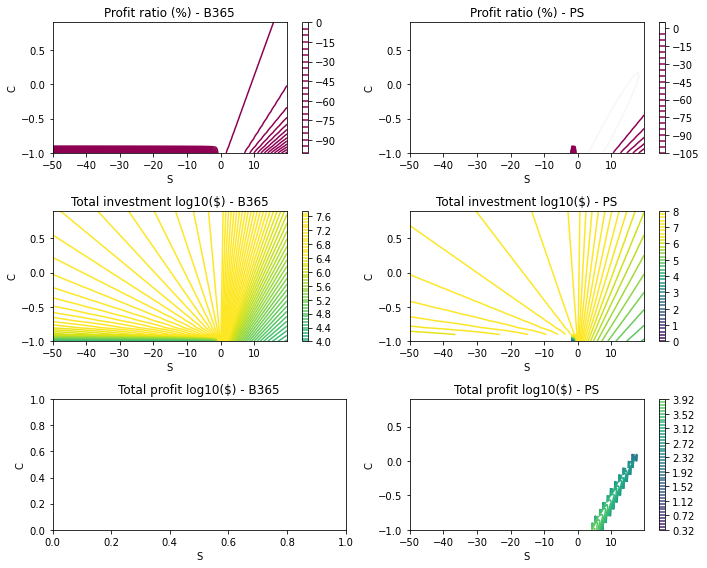

In [424]:
S_range = np.arange(-50,20,0.25)
C_range = np.arange(-1,1,0.1)
max_bet = 10000

PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS = revenue_scan(matrix_j,S_range,C_range,max_bet, model ='SM4')
plot_revenue(S_range,C_range,PR_B365, PR_PS,inv_B365,inv_PS,prf_B365,prf_PS)

Unfortunately, this doesn't seem to be a very good strategy, eventhough these is a narrow parameter regime to get positive return rate

In [163]:
# record a typical profit rate
n = 8
C = -0.5
S = 10
pr_B365, pr_PS,inv_B365,inv_PS,prf_B365,prf_PS,_,_,matrix_com = revenue_SM4(matrix_j,C = C,S=S,max_bet=max_bet)
            
summary.loc[n,'Strategy_code'] = 'SM4'
summary.loc[n,'Strategy'] = 'Bet (p_1 O_1+ C)^S on p1 when O_2>O_1 & p_1>1/O_1'
summary.loc[n,'C'] = C
summary.loc[n,'S'] = S

summary.loc[n,'Ann.PR_ave_B365 (%)'] =  pr_B365/8
summary.loc[n,'Ann.PR_ave_PS (%)'] =  pr_PS/8
# summary.loc[n,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
# summary.loc[n,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%),C,S
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669,NaN,NaN
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003,NaN,NaN
2,C3,A constant bet on both sides,-0.970457,-0.414811,NaN,NaN
3,S1,Bet (O_2/O_1 + C)^S on p1 when O_2/O_1 > 1,-0.609065,0.614508,-0.85,-20.0
4,S2,"Bet (O_2/O_1 + C)^S on p1, and 1 on p2 when O_...",-0.609065,0.614508,-0.85,-20.0
5,SM1,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1>p_2,-0.482294,0.553304,-0.85,-20.0
6,SM2,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1<p_2,0.962800,2.877291,-1.00,-40.0
7,SM3,Bet (O_2/O_1 +p_1/P_2+ C)^S on p1 when O_2>O_1...,8.847204,-12.500000,-2.00,-40.0
8,SM4,Bet (p_1 O_1+ C)^S on p1 when O_2>O_1 & p_1>1/O_1,-0.665376,0.072102,-0.50,10.0


(8) Another betting strategy, which was mentioned in 'Exploiting sports-betting market using machine learning' http://ida.felk.cvut.cz/zelezny/pubs/ijf.2019.pdf, is to have an optimal balance between the profit expectance and variance, and to bet on games with higher certainty in the result:

* Only positive betting on one of the two players, whose winning probability predicted by the machine learning model satisfy
$ |\hat p_i - 0.5| > \phi$

* The betting amount $M_i$ should maximaize the expectation $E$ while minimizing the standard deviation $\sigma$ of the profit $P$, i.e. to maximize the quality factor $Q$ of the betting:

$Q(P) = E(P)/\sigma(P)$

where 

$E(P) = \sum_i^n E(P_i) = \sum_i^n M_i(\hat p_i O_i -1)$,  

$\sigma(P) = \sqrt{\mathrm{Var}(P)}$,  

and the variance of profit  

$\mathrm{Var}(P) = \sum_i^n E(P_i^2) -  [E(P_i)]^2  = \sum_i^n (1-\hat p_i)\hat p_i M_i ^2 O_i^2$

##### * However, in the paper, the authors chose to optimize the betting porfolio based on the probabilites and betting odds from the bookmakers for the entire round of games. This is impossible because in reality the bookmakers never release the betting odds of the entire round of matches at the begining of the round (https://www.pinnacle.com/en/basketball/matchups), but instead the odds are usually released one day at most before the game, and will stop accepting the bet after the game. Therefore, the idea that one can optimize the betting porfolio of a series of matches over a relatively long time (more than two days) is impractical.

* Of course, we can still optimize the porfolio on a two-day basis, provided that if there are more than one bets every two days. 

* Unfortunatly, in the current data set, we only have the starting date for most of the tourneies. So we will go with the strategy of optimizing the betting in a sequencial manner. 

* We will try two different approaches, the first one is to find the optimal betting by considering the expectation and variance of current bet and the past 10 bets using only the probabilities, the second approach is to use the true sum and variance of the past 10 bets. In this case, we only optimize the current bet since the past is known.


We need to re-examine the function of quality factor

x for max Q: 99.99000000000001
x for max Delta: 99.99000000000001
x for max Delta: 21.6


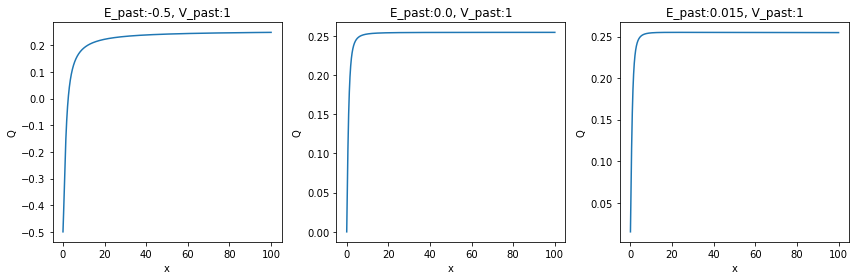

In [186]:
x=np.arange(0,100,0.01)
# E_past=0
# V_past=10
# p = 0.65
# O = 1/p*0.95

def Q(x,E_past,V_past,p,O):
    
    y1 = ((O*p-1)*x+E_past)/np.sqrt((1-p)*p*(x*O)**2+V_past)
    
    y2 = ((O*p-1)*x+E_past)-np.sqrt((1-p)*p*(x*O)**2+V_past)
    
    return y1,y2

plt.figure(figsize = (12,4))

plt.subplot(1,3,1)

V_past=1
E_past=-V_past*0.5
p=0.7
O=1/p*1.2
y1,y2 = Q(x,E_past,V_past,p,O)

plt.plot(x,y1)
plt.title('E_past:{}, V_past:{}'.format(E_past,V_past))
plt.xlabel('x')
plt.ylabel('Q')
print('x for max Q:', x[y1.argmax()])


plt.subplot(1,3,2)

V_past=1
E_past=V_past*0.0
p=0.7
O=1/p*1.2
y1,y2 = Q(x,E_past,V_past,p,O)

plt.plot(x,y1)
plt.title('E_past:{}, V_past:{}'.format(E_past,V_past))
plt.xlabel('x')
plt.ylabel('Q')
print('x for max Delta:', x[y1.argmax()])

plt.subplot(1,3,3)

V_past=1
E_past=V_past*0.015
p=0.7
O=1/p*1.2
y1,y2 = Q(x,E_past,V_past,p,O)

plt.plot(x,y1)
plt.title('E_past:{}, V_past:{}'.format(E_past,V_past))
plt.xlabel('x')
plt.ylabel('Q')
print('x for max Delta:', x[y1.argmax()])
plt.tight_layout()


It turns out that the quality factor function defined as $Q = (E_i + E_{past}) /\sqrt{\mathrm{Var}_{i} + \mathrm{Var}_{past}}$ is highly sensitive the value of the past expectance. If the past expectance becomes negative, the bet will be push to the maximal amount, but if the expectance is positive, it will mostly be a small value.

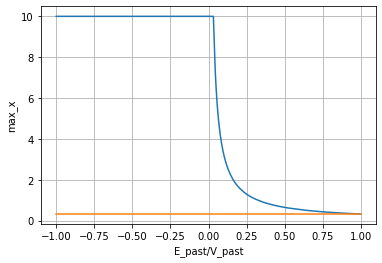

In [35]:
x=np.arange(0,10,0.002)
V_past=1
p=0.7
O=1/p*1.2
y1,y2 = Q(x,E_past,V_past,p,O)

i = 1
max_x1 = []
max_x2 = []
Ratio = np.arange(-1,1,0.002)
for ratio in Ratio:
    E_past=V_past*ratio
    y1,y2 = Q(x,E_past,V_past,p,O)
    max_x1.append(x[y1.argmax()])
    max_x2.append(x[y2.argmax()]) 
    i+=1
    
plt.figure
plt.plot(Ratio,max_x1)
plt.plot(Ratio,max_x2)
plt.xlabel('E_past/V_past')
plt.ylabel('max_x')
plt.grid()


In [3]:
# matrix_j = pd.read_pickle('matrix_j.pkl')
# matrix_j.shape[0]

22319

Now we start asigning the betting amounts iteratively from 2012 to 2020. We use two different strategies, the first one is to calculate the moving cumulative profit expectance and variance purely based on prediction winning probabilities, and optimize the porfolio based on the quality factor, the second is to substitute the expectance and variance with real profit sum and variance in the past, and recalculate the quality factor. 

In [188]:
#define phi to filter matches with high confidence

phi = 0.15
matrix_j ['p2_win_pred']= 1- matrix_j ['p1_win_pred']


cond0 = ((matrix_j['p1_win_pred']>1/matrix_j['B365_p1'])&(matrix_j['p1_win_pred']-0.5>phi))|\
((matrix_j['p2_win_pred']>1/matrix_j['B365_p2'])&(matrix_j['p2_win_pred']-0.5>phi))

cond1 = ((matrix_j['p1_win_pred']>1/matrix_j['PS_p1'])&(matrix_j['p1_win_pred']-0.5>phi))|\
((matrix_j['p2_win_pred']>1/matrix_j['PS_p2'])&(matrix_j['p2_win_pred']-0.5>phi))

cond2 = matrix_j.year>=2012

# choose matches that satisfy the conditions
matrix_phi = matrix_j[(cond0|cond1)&cond2]
matrix_phi.head()

,tourney_name,year,month,p1_name,p2_name,p1_win,p1_win_pred,B365_p1,B365_p2,PS_p1,PS_p2,B365_pred,PS_pred,p2_win_pred,B365_revenue_1,PS_revenue_1,B365_revenue_2,PS_revenue_2,B365_revenue_3,PS_revenue_3
4688,Brisbane,2012,1,Ricardo Mello,Gilles Muller,0.0,0.279701,2.75,1.40,3.13,1.41,0,0,0.720299,0.40,0.41,-1.00,-1.00,-0.60,-0.59
4690,Brisbane,2012,1,Kei Nishikori,Cedrik Marcel Stebe,1.0,0.799529,1.22,4.00,1.26,4.29,1,1,0.200471,0.22,0.26,-1.00,-1.00,-0.78,-0.74
4691,Brisbane,2012,1,Florian Mayer,Denis Istomin,0.0,0.829869,1.33,3.25,1.38,3.29,1,1,0.170131,-1.00,-1.00,2.25,2.29,1.25,1.29
4692,Brisbane,2012,1,Tommy Haas,Marinko Matosevic,1.0,0.873749,1.53,2.37,1.66,2.34,1,1,0.126251,0.53,0.66,-1.00,-1.00,-0.47,-0.34
4695,Brisbane,2012,1,Radek Stepanek,Matthew Ebden,1.0,0.662932,1.50,2.50,1.61,2.46,1,1,0.337068,0.50,0.61,-1.00,-1.00,-0.50,-0.39


* Below we start optimizing the betting in an interactive mannar.
* Since the function Q is very sensitive to netative value of past expectation, to avoid over correcting, we limit the max bet to 10.
* We will use the past 20 bets to calculate the past expectation and variance 

In [77]:
max_bet = 10
last_n = 20

invest = pd.DataFrame()
#profit = pd.DataFrame()
col = ['p1_win','p1_win_pred','p2_win_pred','B365_p1','B365_p2','PS_p1','PS_p2']

invest[col] = matrix_phi[col]
invest['flag_B365_p1'] = (matrix_phi['p1_win_pred']>1/matrix_phi['B365_p1'])&(matrix_phi['p1_win_pred']-0.5>phi)
invest['flag_B365_p2'] = (matrix_phi['p2_win_pred']>1/matrix_phi['B365_p2'])&(matrix_phi['p2_win_pred']-0.5>phi)
invest['flag_PS_p1'] = (matrix_phi['p1_win_pred']>1/matrix_phi['PS_p1'])&(matrix_phi['p1_win_pred']-0.5>phi)
invest['flag_PS_p2'] = (matrix_phi['p2_win_pred']>1/matrix_phi['PS_p2'])&(matrix_phi['p2_win_pred']-0.5>phi)
invest = 1*invest

matrix_phi['p2_win'] = 1-matrix_phi['p1_win']

# define a range of betting to find the optimal bet amount

M_range = np.arange(0,max_bet,0.01)

for i in matrix_phi.index:

    # set the initial value to $1 for the first bet
    if i== min(invest[(invest.flag_B365_p1==1) | (invest.flag_B365_p2 == 1)].index):

        M_a = 1
        M_b = 1
        # update the bet amount using strategy a
        invest.loc[i,'B365_p1_I_a'] = invest.loc[i,'flag_B365_p1']*M_a
        invest.loc[i,'B365_p2_I_a'] = invest.loc[i,'flag_B365_p2']*M_a

        # update the bet amount using strategy b
        invest.loc[i,'B365_p1_I_b'] = invest.loc[i,'flag_B365_p1']*M_b
        invest.loc[i,'B365_p2_I_b'] = invest.loc[i,'flag_B365_p2']*M_b

        invest.loc[i,'M_B365_a'] = M_a
        invest.loc[i,'M_B365_b'] = M_b

        # expectance and variance of profit using strategy a
        E_B365_a = M_a*(invest.loc[i,'flag_B365_p1']*(matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'B365_p1']-1)+\
                    invest.loc[i,'flag_B365_p2']*(matrix_phi.loc[i,'p2_win_pred']*matrix_phi.loc[i,'B365_p2']-1))

        V_B365_a = M_a**2*matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'p2_win_pred']*\
                    (invest.loc[i,'flag_B365_p1']*(matrix_phi.loc[i,'B365_p1'])**2+\
                    invest.loc[i,'flag_B365_p2']*(matrix_phi.loc[i,'B365_p2'])**2)

        Q_B365_a = E_B365_a/np.sqrt(V_B365_a)

        # expectance and variance of profit using strategy b

        E_B365_b = M_b*(invest.loc[i,'flag_B365_p1']*(matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'B365_p1']-1)+\
                    invest.loc[i,'flag_B365_p2']*(matrix_phi.loc[i,'p2_win_pred']*matrix_phi.loc[i,'B365_p2']-1))

        V_B365_b = M_b**2*matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'p2_win_pred']*\
                    (invest.loc[i,'flag_B365_p1']*(matrix_phi.loc[i,'B365_p1'])**2+\
                    invest.loc[i,'flag_B365_p2']*(matrix_phi.loc[i,'B365_p2'])**2)

        Q_B365_b = E_B365_b/np.sqrt(V_B365_b)

        # record the values
        invest.loc[i,'EP_B365_a'] = E_B365_a
        invest.loc[i,'VP_B365_a'] = V_B365_a
        invest.loc[i,'Q_B365_a'] = Q_B365_a

        invest.loc[i,'EP_B365_b'] = E_B365_b
        invest.loc[i,'VP_B365_b'] = V_B365_b
        invest.loc[i,'Q_B365_b'] = Q_B365_b

        # actual profit
        invest.loc[i,'P_B365_a'] = invest.loc[i,'B365_p1_I_a']*(matrix_phi.loc[i,'p1_win']*matrix_phi.loc[i,'B365_p1']-1)+\
                                invest.loc[i,'B365_p2_I_a']*((1-matrix_phi.loc[i,'p1_win'])*matrix_phi.loc[i,'B365_p2']-1)

        invest.loc[i,'P_B365_b'] = invest.loc[i,'B365_p1_I_b']*(matrix_phi.loc[i,'p1_win']*matrix_phi.loc[i,'B365_p1']-1)+\
                                invest.loc[i,'B365_p2_I_b']*((1-matrix_phi.loc[i,'p1_win'])*matrix_phi.loc[i,'B365_p2']-1)

        # actual accumulative profit
        invest.loc[i,'PAC_B365_a'] = invest.loc[:i,'P_B365_a'].sum()
        invest.loc[i,'PAC_B365_b'] = invest.loc[:i,'P_B365_b'].sum()

        # actual variance of profit
        invest.loc[i,'VAC_B365_a'] = V_B365_a 
        invest.loc[i,'VAC_B365_b'] = V_B365_b


    # if the game is to be bet on via B365

    elif (invest.loc[i,'flag_B365_p1']==1) or (invest.loc[i,'flag_B365_p2'] == 1):


        # find the last overall expectance and variance of profit

        # for strategy a, we use the calculated expectance and variance of the past bets
#         ind_a = invest.loc[:i-1,'EP_B365_a'][invest.M_B365_a>0].index.max()
#         E_B365_past_a = invest.loc[ind_a,'EP_B365_a']#invest.loc[ind_a,'EP_B365_a']
#         V_B365_past_a = #invest.loc[ind_a,'VP_B365_a']
        
    # for strategy a, we use the calculated expectance and variance of the past 20 bets
        ind_a = invest.loc[:i-1,'EP_B365_a'][invest.M_B365_a>0].index
        
        if ind_a.shape[0]>last_n:
            ind_a = ind_a[-last_n-1:-1]
            
        E_B365_past_a = (invest.loc[ind_a,'B365_p1_I_a']*(matrix_phi.loc[ind_a,'p1_win_pred']*matrix_phi.loc[ind_a,'B365_p1']-1)).sum()+\
                        (invest.loc[ind_a,'B365_p2_I_a']*(matrix_phi.loc[ind_a,'p2_win_pred']*matrix_phi.loc[ind_a,'B365_p2']-1)).sum()
        V_B365_past_a = ((invest.loc[ind_a,'B365_p1_I_a']*matrix_phi.loc[ind_a,'B365_p1'])**2*matrix_phi.loc[ind_a,'p1_win_pred']*(1-matrix_phi.loc[ind_a,'p1_win_pred'])).sum()+\
                        ((invest.loc[ind_a,'B365_p2_I_a']*matrix_phi.loc[ind_a,'B365_p2'])**2*matrix_phi.loc[ind_a,'p2_win_pred']*(1-matrix_phi.loc[ind_a,'p2_win_pred'])).sum()\
                               
        # for strategy b, we use the actual sum and variance
#         ind_b = invest.loc[:i-1,'EP_B365_b'][invest.M_B365_b>0].index.max()
#         E_B365_past_b = invest.loc[ind_b,'PAC_B365_b']
#         V_B365_past_b = invest.loc[ind_b,'VAC_B365_b']
        
        ind_b = invest.loc[:i-1,'EP_B365_b'][invest.M_B365_b>0].index
        
        if ind_b.shape[0]>last_n:
            ind_b = ind_b[-last_n-1:-1]
            
        E_B365_past_b = invest.loc[ind_b,'P_B365_b'].sum()
        
        if ind_b.shape[0]>1:
            V_B365_past_b = statistics.variance(invest.loc[ind_b,'P_B365_b'])*(ind_b.shape[0])
        else:
            V_B365_past_b = V_B365_past_a
            
                                
        # the range of profit expectance and variance after betting on the current game
        E_B365_a = E_B365_past_a + M_range*(invest.loc[i,'flag_B365_p1']*(matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'B365_p1']-1)+\
                    invest.loc[i,'flag_B365_p2']*(matrix_phi.loc[i,'p2_win_pred']*matrix_phi.loc[i,'B365_p2']-1))

        E_B365_b = E_B365_past_b + M_range*(invest.loc[i,'flag_B365_p1']*(matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'B365_p1']-1)+\
                    invest.loc[i,'flag_B365_p2']*(matrix_phi.loc[i,'p2_win_pred']*matrix_phi.loc[i,'B365_p2']-1))

        V_B365_a = V_B365_past_a + M_range**2*\
                    matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'p2_win_pred']*\
                    (invest.loc[i,'flag_B365_p1']*(matrix_phi.loc[i,'B365_p1'])**2+\
                    invest.loc[i,'flag_B365_p2']*(matrix_phi.loc[i,'B365_p2'])**2)

        V_B365_b = V_B365_past_b + M_range**2*\
                    matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'p2_win_pred']*\
                    (invest.loc[i,'flag_B365_p1']*(matrix_phi.loc[i,'B365_p1'])**2+\
                    invest.loc[i,'flag_B365_p2']*(matrix_phi.loc[i,'B365_p2'])**2)

        Q_B365_a = E_B365_a/np.sqrt(V_B365_a)

        Q_B365_b = E_B365_b/np.sqrt(V_B365_b)
        

        # find the bet that maximize the Q-factor
        j_a = Q_B365_a.argmax()
        M_a = M_range[j_a]
        Q_a = Q_B365_a[j_a]

        j_b = Q_B365_b.argmax()
        M_b = M_range[j_b]
        Q_b = Q_B365_b[j_b]

        # update the bet amount
        invest.loc[i,'B365_p1_I_a'] = invest.loc[i,'flag_B365_p1']*M_a
        invest.loc[i,'B365_p2_I_a'] = invest.loc[i,'flag_B365_p2']*M_a
        invest.loc[i,'M_B365_a'] = M_a        
        invest.loc[i,'Q_B365_a'] = Q_a

        invest.loc[i,'B365_p1_I_b'] = invest.loc[i,'flag_B365_p1']*M_b
        invest.loc[i,'B365_p2_I_b'] = invest.loc[i,'flag_B365_p2']*M_b
        invest.loc[i,'M_B365_b'] = M_b        
        invest.loc[i,'Q_B365_b'] = Q_b

        # update the expectance and variance of profit
        invest.loc[i,'EP_B365_a'] = E_B365_a[j_a]
        invest.loc[i,'VP_B365_a'] = V_B365_a[j_a]

        invest.loc[i,'EP_B365_b'] = E_B365_b[j_b]
        invest.loc[i,'VP_B365_b'] = V_B365_b[j_b]

        # actual profit
        invest.loc[i,'P_B365_a'] = invest.loc[i,'B365_p1_I_a']*(matrix_phi.loc[i,'p1_win']*matrix_phi.loc[i,'B365_p1']-1)+\
                                invest.loc[i,'B365_p2_I_a']*((1-matrix_phi.loc[i,'p1_win'])*matrix_phi.loc[i,'B365_p2']-1)

        invest.loc[i,'P_B365_b'] = invest.loc[i,'B365_p1_I_b']*(matrix_phi.loc[i,'p1_win']*matrix_phi.loc[i,'B365_p1']-1)+\
                                invest.loc[i,'B365_p2_I_b']*((1-matrix_phi.loc[i,'p1_win'])*matrix_phi.loc[i,'B365_p2']-1)

        # actual accumulative profit
        invest.loc[i,'PAC_B365_a'] = invest.loc[:i,'P_B365_a'].sum()
        invest.loc[i,'PAC_B365_b'] = invest.loc[:i,'P_B365_b'].sum()

        # actual variance of profit
        invest.loc[i,'VAC_B365_a'] = statistics.variance(invest.loc[:i,'P_B365_a'][abs(invest.P_B365_a)>0],xbar=1)*(invest.loc[:i,'P_B365_a'][abs(invest.P_B365_a)>0].count()) # xbar is the mean factor, here we don't need to
        invest.loc[i,'VAC_B365_b'] = statistics.variance(invest.loc[:i,'P_B365_b'][abs(invest.P_B365_b)>0],xbar=1)*(invest.loc[:i,'P_B365_b'][abs(invest.P_B365_b)>0].count())

# set the initial value to $1 for the first bet
    if i== min(invest[(invest.flag_PS_p1==1) | (invest.flag_PS_p2 == 1)].index):

        M_a = 1
        M_b = 1
        # update the bet amount using strategy a
        invest.loc[i,'PS_p1_I_a'] = invest.loc[i,'flag_PS_p1']*M_a
        invest.loc[i,'PS_p2_I_a'] = invest.loc[i,'flag_PS_p2']*M_a

        # update the bet amount using strategy b
        invest.loc[i,'PS_p1_I_b'] = invest.loc[i,'flag_PS_p1']*M_b
        invest.loc[i,'PS_p2_I_b'] = invest.loc[i,'flag_PS_p2']*M_b

        invest.loc[i,'M_PS_a'] = M_a
        invest.loc[i,'M_PS_b'] = M_b

        # expectance and variance of profit using strategy a
        E_PS_a = M_a*(invest.loc[i,'flag_PS_p1']*(matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'PS_p1']-1)+\
                    invest.loc[i,'flag_PS_p2']*(matrix_phi.loc[i,'p2_win_pred']*matrix_phi.loc[i,'PS_p2']-1))

        V_PS_a = M_a**2*matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'p2_win_pred']*\
                    (invest.loc[i,'flag_PS_p1']*(matrix_phi.loc[i,'PS_p1'])**2+\
                    invest.loc[i,'flag_PS_p2']*(matrix_phi.loc[i,'PS_p2'])**2)

        Q_PS_a = E_PS_a/np.sqrt(V_PS_a)

        # expectance and variance of profit using strategy b

        E_PS_b = M_b*(invest.loc[i,'flag_PS_p1']*(matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'PS_p1']-1)+\
                    invest.loc[i,'flag_PS_p2']*(matrix_phi.loc[i,'p2_win_pred']*matrix_phi.loc[i,'PS_p2']-1))

        V_PS_b = M_b**2*matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'p2_win_pred']*\
                    (invest.loc[i,'flag_PS_p1']*(matrix_phi.loc[i,'PS_p1'])**2+\
                    invest.loc[i,'flag_PS_p2']*(matrix_phi.loc[i,'PS_p2'])**2)

        Q_PS_b = E_PS_b/np.sqrt(V_PS_b)

        # record the values
        invest.loc[i,'EP_PS_a'] = E_PS_a
        invest.loc[i,'VP_PS_a'] = V_PS_a
        invest.loc[i,'Q_PS_a'] = Q_PS_a

        invest.loc[i,'EP_PS_b'] = E_PS_b
        invest.loc[i,'VP_PS_b'] = V_PS_b
        invest.loc[i,'Q_PS_b'] = Q_PS_b

        # actual profit
        invest.loc[i,'P_PS_a'] = invest.loc[i,'PS_p1_I_a']*(matrix_phi.loc[i,'p1_win']*matrix_phi.loc[i,'PS_p1']-1)+\
                                invest.loc[i,'PS_p2_I_a']*((1-matrix_phi.loc[i,'p1_win'])*matrix_phi.loc[i,'PS_p2']-1)

        invest.loc[i,'P_PS_b'] = invest.loc[i,'PS_p1_I_b']*(matrix_phi.loc[i,'p1_win']*matrix_phi.loc[i,'PS_p1']-1)+\
                                invest.loc[i,'PS_p2_I_b']*((1-matrix_phi.loc[i,'p1_win'])*matrix_phi.loc[i,'PS_p2']-1)

        # actual accumulative profit
        invest.loc[i,'PAC_PS_a'] = invest.loc[:i,'P_PS_a'].sum()
        invest.loc[i,'PAC_PS_b'] = invest.loc[:i,'P_PS_b'].sum()

        # actual variance of profit
        invest.loc[i,'VAC_PS_a'] = V_PS_a 
        invest.loc[i,'VAC_PS_b'] = V_PS_b


    # if the game is to be bet on via PS

    elif (invest.loc[i,'flag_PS_p1']==1) or (invest.loc[i,'flag_PS_p2'] == 1):

        # find the last overall expectance and variance of profit

        # for strategy a, we use the calculated expectance and variance
#         ind_a = invest.loc[:i-1,'EP_PS_a'][invest.M_PS_a>0].index.max()
#         E_PS_past_a = invest.loc[ind_a,'EP_PS_a']
#         V_PS_past_a = invest.loc[ind_a,'VP_PS_a']
        
        ind_a = invest.loc[:i-1,'EP_PS_a'][invest.M_PS_a>0].index
        
        if ind_a.shape[0]>last_n:
            ind_a = ind_a[-last_n-1:-1]
            
        E_PS_past_a = (invest.loc[ind_a,'PS_p1_I_a']*(matrix_phi.loc[ind_a,'p1_win_pred']*matrix_phi.loc[ind_a,'PS_p1']-1)).sum()+\
                        (invest.loc[ind_a,'PS_p2_I_a']*(matrix_phi.loc[ind_a,'p2_win_pred']*matrix_phi.loc[ind_a,'PS_p2']-1)).sum()
        V_PS_past_a = ((invest.loc[ind_a,'PS_p1_I_a']*matrix_phi.loc[ind_a,'PS_p1'])**2*matrix_phi.loc[ind_a,'p1_win_pred']*(1-matrix_phi.loc[ind_a,'p1_win_pred'])).sum()+\
                        ((invest.loc[ind_a,'PS_p2_I_a']*matrix_phi.loc[ind_a,'PS_p2'])**2*matrix_phi.loc[ind_a,'p2_win_pred']*(1-matrix_phi.loc[ind_a,'p2_win_pred'])).sum()\

        # for strategy b, we use the actual sum and variance
#         ind_b = invest.loc[:i-1,'EP_PS_b'][invest.M_PS_b>0].index.max()
#         E_PS_past_b = invest.loc[ind_b,'PAC_PS_b']
#         V_PS_past_b = invest.loc[ind_b,'VAC_PS_b']
        
        ind_b = invest.loc[:i-1,'EP_PS_b'][invest.M_PS_b>0].index
        
        if ind_b.shape[0]>last_n:
            ind_b = ind_b[-last_n-1:-1]
        
        E_PS_past_b = invest.loc[ind_b,'P_PS_b'].sum()
        
        if ind_b.shape[0]>1:
            V_PS_past_b = statistics.variance(invest.loc[ind_b,'P_PS_b'])*(ind_b.shape[0])
        else:
            V_PS_past_b = V_PS_past_a
            
        

        # the range of profit expectance and variance after betting on the current game
        E_PS_a = E_PS_past_a + M_range*(invest.loc[i,'flag_PS_p1']*(matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'PS_p1']-1)+\
                    invest.loc[i,'flag_PS_p2']*(matrix_phi.loc[i,'p2_win_pred']*matrix_phi.loc[i,'PS_p2']-1))

        E_PS_b = E_PS_past_b + M_range*(invest.loc[i,'flag_PS_p1']*(matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'PS_p1']-1)+\
                    invest.loc[i,'flag_PS_p2']*(matrix_phi.loc[i,'p2_win_pred']*matrix_phi.loc[i,'PS_p2']-1))

        V_PS_a = V_PS_past_a + M_range**2*\
                    matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'p2_win_pred']*\
                    (invest.loc[i,'flag_PS_p1']*(matrix_phi.loc[i,'PS_p1'])**2+\
                    invest.loc[i,'flag_PS_p2']*(matrix_phi.loc[i,'PS_p2'])**2)

        V_PS_b = V_PS_past_b + M_range**2*\
                    matrix_phi.loc[i,'p1_win_pred']*matrix_phi.loc[i,'p2_win_pred']*\
                    (invest.loc[i,'flag_PS_p1']*(matrix_phi.loc[i,'PS_p1'])**2+\
                    invest.loc[i,'flag_PS_p2']*(matrix_phi.loc[i,'PS_p2'])**2)

        Q_PS_a = E_PS_a/np.sqrt(V_PS_a)

        Q_PS_b = E_PS_b/np.sqrt(V_PS_b)
                
#         plt.figure(1)
#         plt.plot(Q_range_a)
#         plt.plot(Q_range_b)
#         plt.legend(['Q_a','Q_b'])
#         plt.title('PS')

        # find the bet that maximize the Q-factor
        j_a = Q_PS_a.argmax()
        M_a = M_range[j_a]
        Q_a = Q_PS_a[j_a]

        j_b = Q_PS_b.argmax()
        M_b = M_range[j_b]
        Q_b = Q_PS_b[j_b]

        # update the bet amount
        invest.loc[i,'PS_p1_I_a'] = invest.loc[i,'flag_PS_p1']*M_a
        invest.loc[i,'PS_p2_I_a'] = invest.loc[i,'flag_PS_p2']*M_a
        invest.loc[i,'M_PS_a'] = M_a        
        invest.loc[i,'Q_PS_a'] = Q_a

        invest.loc[i,'PS_p1_I_b'] = invest.loc[i,'flag_PS_p1']*M_b
        invest.loc[i,'PS_p2_I_b'] = invest.loc[i,'flag_PS_p2']*M_b
        invest.loc[i,'M_PS_b'] = M_b        
        invest.loc[i,'Q_PS_b'] = Q_b

        # update the expectance and variance of profit
        invest.loc[i,'EP_PS_a'] = E_PS_a[j_a]
        invest.loc[i,'VP_PS_a'] = V_PS_a[j_a]

        invest.loc[i,'EP_PS_b'] = E_PS_b[j_b]
        invest.loc[i,'VP_PS_b'] = V_PS_b[j_b]

        # actual profit
        invest.loc[i,'P_PS_a'] = invest.loc[i,'PS_p1_I_a']*(matrix_phi.loc[i,'p1_win']*matrix_phi.loc[i,'PS_p1']-1)+\
                                invest.loc[i,'PS_p2_I_a']*((1-matrix_phi.loc[i,'p1_win'])*matrix_phi.loc[i,'PS_p2']-1)

        invest.loc[i,'P_PS_b'] = invest.loc[i,'PS_p1_I_b']*(matrix_phi.loc[i,'p1_win']*matrix_phi.loc[i,'PS_p1']-1)+\
                                invest.loc[i,'PS_p2_I_b']*((1-matrix_phi.loc[i,'p1_win'])*matrix_phi.loc[i,'PS_p2']-1)

        # actual accumulative profit
        invest.loc[i,'PAC_PS_a'] = invest.loc[:i,'P_PS_a'].sum()
        invest.loc[i,'PAC_PS_b'] = invest.loc[:i,'P_PS_b'].sum()

        # actual variance of profit        
        invest.loc[i,'VAC_PS_a'] = statistics.variance(invest.loc[:i,'P_PS_a'][abs(invest.P_PS_a)>0],xbar=1)*(invest.loc[:i,'P_PS_a'][abs(invest.P_PS_a)>0].count()) # xbar is the mean factor, here we don't need to
        invest.loc[i,'VAC_PS_b'] = statistics.variance(invest.loc[:i,'P_PS_b'][abs(invest.P_PS_b)>0],xbar=1)*(invest.loc[:i,'P_PS_b'][abs(invest.P_PS_b)>0].count())

    # show progress
    
        i_min = min(matrix_phi.index)
        i_max = max(matrix_phi.index)
        tot_len = (i_max-i_min)
        if i == i_min:
            print('Start calculating Elo ratings:')
            
        sys.stdout.write('\r')
        progress = round(100*(i-i_min)/tot_len);
                         
        if progress % 5 == 0:
            sys.stdout.write("{}%".format(progress))      
            sys.stdout.flush()
            sleep(0.02)



C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


100%

In [78]:
col = ['M_B365_a','P_B365_a','PAC_B365_a','M_PS_a','P_PS_a','PAC_PS_a',
       'M_B365_b','P_B365_b','PAC_B365_b','M_PS_b','P_PS_b','PAC_PS_b']

matrix_phi[col] = invest[col]

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [165]:
invest

,p1_win,p1_win_pred,p2_win_pred,B365_p1,B365_p2,PS_p1,PS_p2,flag_B365_p1,flag_B365_p2,flag_PS_p1,flag_PS_p2,B365_p1_I_a,B365_p2_I_a,B365_p1_I_b,B365_p2_I_b,M_B365_a,M_B365_b,EP_B365_a,VP_B365_a,Q_B365_a,EP_B365_b,VP_B365_b,Q_B365_b,P_B365_a,P_B365_b,PAC_B365_a,PAC_B365_b,VAC_B365_a,VAC_B365_b,PS_p1_I_a,PS_p2_I_a,PS_p1_I_b,PS_p2_I_b,M_PS_a,M_PS_b,EP_PS_a,VP_PS_a,Q_PS_a,EP_PS_b,VP_PS_b,Q_PS_b,P_PS_a,P_PS_b,PAC_PS_a,PAC_PS_b,VAC_PS_a,VAC_PS_b
4688,0.0,0.279701,0.720299,2.75,1.40,3.13,1.41,0,1,0,1,0.00,1.00,0.00,1.00,1.00,1.00,0.008419,0.394878,0.013397,0.008419,0.394878,0.013397,0.4000,0.4000,0.4000,0.40000,0.394878,0.394878,0.00,1.00,0.00,1.00,1.00,1.00,0.015622,0.400539,0.024684,0.015622,0.400539,0.024684,0.4100,0.4100,0.41000,0.41000,0.400539,0.400539
4690,1.0,0.799529,0.200471,1.22,4.00,1.26,4.29,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.00,0.03,0.00,0.75,0.03,0.021176,0.543675,0.028720,0.410222,0.400768,0.647996,0.1950,0.0078,0.60500,0.41780,0.046225,0.161765
4691,0.0,0.829869,0.170131,1.33,3.25,1.38,3.29,1,0,1,0,9.99,0.00,0.41,0.00,9.99,0.41,1.044646,25.319369,0.207607,0.442528,0.436860,0.669529,-9.9900,-0.4100,-9.5900,-0.01000,107.952100,0.656100,9.99,0.00,0.21,0.00,9.99,0.21,1.471923,27.377414,0.281312,0.448296,0.173622,1.075876,-9.9900,-0.2100,-9.38500,0.20780,105.970225,0.296801
4692,1.0,0.873749,0.126251,1.53,2.37,1.66,2.34,1,0,1,0,9.99,0.00,9.99,0.00,9.99,9.99,4.409644,51.090532,0.616926,3.354998,26.427263,0.652629,5.2947,5.2947,-4.2953,5.28470,182.766121,28.578895,9.99,0.00,2.12,0.00,9.99,2.12,5.971660,57.714044,0.786057,1.162699,1.662981,0.901620,6.5934,1.3992,-2.79160,1.60700,188.707855,2.032546
4695,1.0,0.662932,0.337068,1.50,2.50,1.61,2.46,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12,0.00,0.15,0.00,1.12,0.15,6.047058,58.440609,0.791019,1.617098,2.045578,1.130650,0.6832,0.0915,-2.10840,1.69850,178.821051,2.001767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22452,0.0,0.203101,0.796899,3.00,1.40,3.20,1.41,0,1,0,1,0.00,0.58,0.00,9.99,0.58,9.99,4.177130,6.604554,1.625385,31.325231,1235.561632,0.891173,0.2320,3.9960,-384.2812,-3117.61575,13055.929251,341937.180758,0.00,0.60,0.00,9.99,0.60,9.99,4.510434,7.039841,1.699953,40.560541,1148.107774,1.197050,0.2460,4.0959,-214.26065,-1722.65205,11189.456965,306608.491644
22458,1.0,0.757215,0.242785,1.30,3.50,1.36,3.49,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14,0.00,3.00,0.00,0.14,3.00,3.731501,5.824547,1.546153,24.429938,835.199459,0.845332,0.0504,1.0800,-214.21025,-1721.57205,11189.463377,306610.253388
22462,0.0,0.695382,0.304618,1.90,1.80,1.89,1.99,1,0,1,0,0.66,0.00,9.99,0.00,0.66,9.99,4.268572,6.746240,1.643432,45.866344,1133.866959,1.362113,-0.6600,-9.9900,-384.9412,-3127.60575,13056.281532,342026.563678,0.65,0.00,9.99,0.00,0.65,9.99,3.730533,5.825311,1.545651,29.877676,915.832013,0.987277,-0.6500,-9.9900,-214.86025,-1731.56205,11189.846151,306705.123519
22466,0.0,0.316166,0.683834,2.75,1.40,2.88,1.47,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.02,0.00,0.43,0.02,0.43,3.476402,5.429038,1.491999,20.727451,803.694664,0.731140,0.0094,0.2021,-214.85085,-1731.35995,11189.847564,306705.322332


Now we have a look how the accumulative profit change, and how the bets are distributed. 

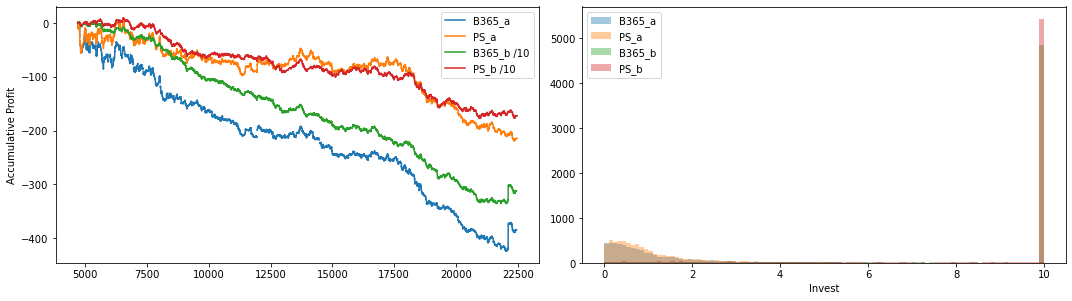

In [84]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
plt.plot(matrix_phi.index,matrix_phi.PAC_B365_a)
plt.plot(matrix_phi.index,matrix_phi.PAC_PS_a)
plt.plot(matrix_phi.index,matrix_phi.PAC_B365_b/10)
plt.plot(matrix_phi.index,matrix_phi.PAC_PS_b/10)
plt.legend(['B365_a','PS_a','B365_b /10','PS_b /10'])
plt.ylabel('Accumulative Profit')

plt.subplot(2,2,2)
sns.distplot(invest.M_B365_a,bins= 100,kde=False)
sns.distplot(invest.M_PS_a,bins= 100,kde=False)
sns.distplot(invest.M_B365_b,bins= 100,kde=False)
sns.distplot(invest.M_PS_b,bins= 100,kde=False)
plt.legend(['B365_a','PS_a','B365_b','PS_b'])
plt.xlabel('Invest')

plt.tight_layout()

* The accumulative profit for all four investments are all negative. Betting strategy b lost more money than strategy a. 
* Looking at the investment graph, as expected, for betting strategy a, most investment focus on small amounts close to zeros, while for strategy b, most get to the maximal. This explain why strategy b has worse performance: if the past profit is negative, it will lead to maximal bet in the next game.

In [167]:
# record a typical profit rate
n = 10

summary.loc[n,'Strategy_code'] = 'SM6'
summary.loc[n,'Strategy'] = 'Bet B on p1 to maximize the ratio of profit expectation and variance,using true sum and variance in the past'
#summary.loc[n,'C'] = C
#summary.loc[n,'S'] = S

pr_B365 = (invest.P_B365_b).sum()/(invest.M_B365_b).sum()
pr_PS = (invest.P_PS_b).sum()/(invest.M_PS_b).sum()

summary.loc[n,'Ann.PR_ave_B365 (%)'] =  pr_B365/8
summary.loc[n,'Ann.PR_ave_PS (%)'] =  pr_PS/8
# summary.loc[n,'Ann.PR_std_B365 (%)'] =  APR_B365_std/8
# summary.loc[n,'Ann.PR_std_PS (%)'] =  APR_PS_std/8
summary

,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%),C,S
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669,NaN,NaN
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003,NaN,NaN
2,C3,A constant bet on both sides,-0.970457,-0.414811,NaN,NaN
3,S1,Bet (O_2/O_1 + C)^S on p1 when O_2/O_1 > 1,-0.609065,0.614508,-0.85,-20.0
4,S2,"Bet (O_2/O_1 + C)^S on p1, and 1 on p2 when O_...",-0.609065,0.614508,-0.85,-20.0
5,SM1,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1>p_2,-0.482294,0.553304,-0.85,-20.0
6,SM2,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1<p_2,0.962800,2.877291,-1.00,-40.0
7,SM3,Bet (O_2/O_1 +p_1/P_2+ C)^S on p1 when O_2>O_1...,8.847204,-12.500000,-2.00,-40.0
8,SM4,Bet (p_1 O_1+ C)^S on p1 when O_2>O_1 & p_1>1/O_1,-0.665376,0.072102,-0.50,10.0
9,SM5,Bet B on p1 to maximize the ratio of profit ex...,-0.007009,-0.003318,NaN,NaN


<a id='performance'></a>
 ##  5. [Performance Comparison](#Content)

 * We can choose several representative betting model and parameters to check what are the matches chosen to invest and get profit.

In [579]:
# define a function to plot the distribution of revenue 

def dist_revenue(matrix_j,C,S,max_bet,model = 'S'):
    
    if model == 'S':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_S(matrix_j,C,S,max_bet)
    elif model == 'S2':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_S2(matrix_j,C,S,max_bet)
    elif model == 'SM':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_SM(matrix_j,C,S,max_bet)
    elif model == 'SM2':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_SM2(matrix_j,C,S,max_bet)
    elif model == 'SM3':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_SM3(matrix_j,C,S,max_bet)
    elif model == 'SM4':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_SM4(matrix_j,C,S,max_bet)

    Bet_ratio_PS = matrix_com['PS_p1']/matrix_com['PS_p2']
    Bet_ratio_B365 = matrix_com['B365_p1']/matrix_com['B365_p2']

    print('total_invest_B365:', total_invest_b365)
    print('total_prf_B365:', total_prf_b365)
    print('PR_B365:',PR_b365)

    print('total_invest_PS:', total_invest_ps)
    print('total_prf_PS:',total_prf_ps) 
    print('PR_PS:', PR_ps)


    plt.figure(figsize =(12,5))
    plt.subplot(2,2,1)
    sns.distplot(invest[invest['B365']>0],kde=False,bins = 101)
    sns.distplot(profit[invest['B365']>0],kde=False,bins = 201)
    plt.legend(['investment','profit'])
    #plt.yscale('log')
    plt.xlabel('$')
    plt.title('B365')

    plt.subplot(2,2,3)
    sns.distplot(Bet_ratio_B365[profit['B365']<0],kde=False,bins = 51)
    sns.distplot(Bet_ratio_B365[profit['B365']>0],kde=False,bins = 51)
    plt.legend(['profit<0','profit>0'])
    plt.xlabel('Bet_ratio_P1/P2')
    #plt.yscale('log')
    plt.tight_layout()
    
    plt.subplot(2,2,2)
    sns.distplot(invest[invest['PS']>0],kde=False,bins = 101)
    sns.distplot(profit[invest['PS']>0],kde=False,bins = 201)
    plt.legend(['investment','profit'])
    #plt.yscale('log')
    plt.xlabel('$')
    plt.title('PS')

    plt.subplot(2,2,4)
    sns.distplot(Bet_ratio_PS[profit['PS']<0],kde=False,bins = 51)
    sns.distplot(Bet_ratio_PS[profit['PS']>0],kde=False,bins = 51)
    plt.legend(['profit<0','profit>0'])
    plt.xlabel('Bet_ratio_P1/P2')
    #plt.yscale('log')
    plt.tight_layout()
    
    return



* For model 'S1', with parameters C=-0.85, S=-30

total_invest_B365: 3151391.0
total_prf_B365: -151495.44999999995
PR_B365: -4.807256541635105
total_invest_PS: 1169001.0
total_prf_PS: 39430.48999999995
PR_PS: 3.373007379805488


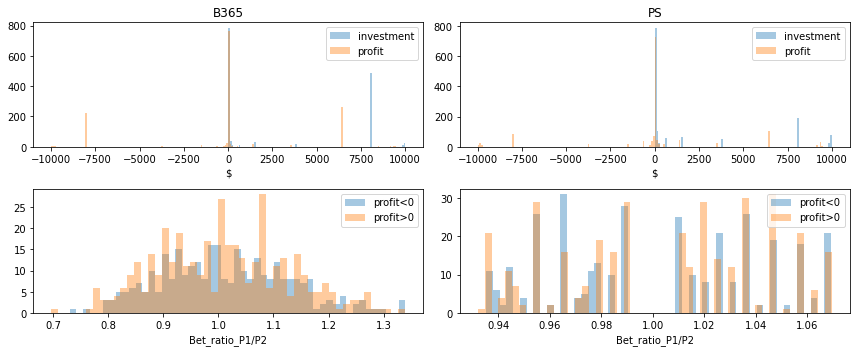

In [460]:
dist_revenue(matrix_j,C=-0.85,S=-30,max_bet=10000,model = 'S1')

total_invest_B365: 41492.0
total_prf_B365: -154.8960000000002
PR_B365: -0.3733153378964625
total_invest_PS: 19143.0
total_prf_PS: 33.76000000000005
PR_PS: 0.17635689285900874


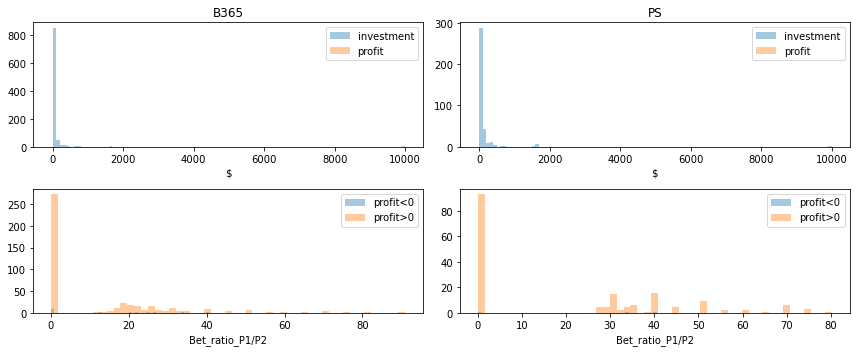

In [461]:
dist_revenue(matrix_j,C=0,S=6.6,max_bet=10000,model = 'S')

* For model 'SM2', with parameters C=-1, S=-10

total_invest_B365: 1384387.0
total_prf_B365: -83586.19999999992
PR_B365: -6.037777008885516
total_invest_PS: 333966.0
total_prf_PS: 36930.999999999985
PR_PS: 11.058311325104947


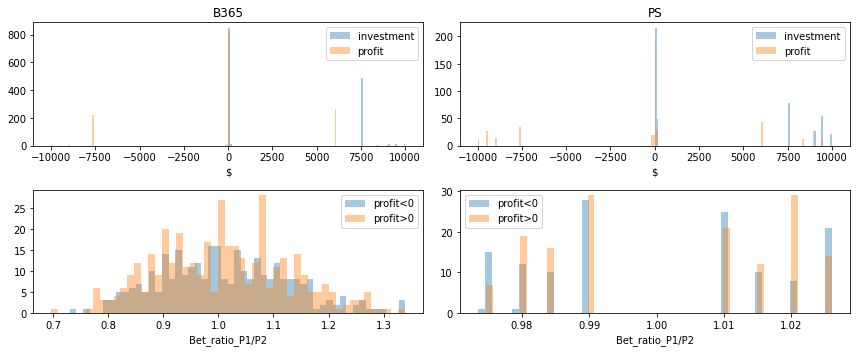

In [462]:
dist_revenue(matrix_j,C=-1.0,S=-10,max_bet=10000,model = 'SM2')

It's quite counter-intuitive that the result do suggest to bet more on the most uncertain games, i.e. when the bookmakers and the machine learning model show different predictions on winners, and the closer the ratio of the two players' betting odds is, the more likely we can get profit by betting on these games. 

* For model 'SM3', with parameters C=-1, S=5

total_invest_B365: 299411.0
total_prf_B365: -6085.123950252748
PR_B365: -2.0323648597589092
total_invest_PS: 435157.0
total_prf_PS: 6155.792129206442
PR_PS: 1.4146140655456403


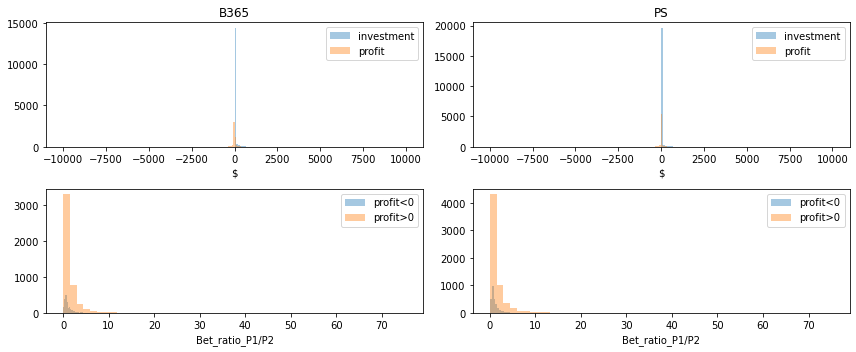

In [463]:
dist_revenue(matrix_j,C=-1,S=5.5,max_bet=10000,model = 'SM3')

total_invest_B365: 26092.0
total_prf_B365: 278208.7095477104
PR_B365: 1066.2605762214869
total_invest_PS: 504057.0
total_prf_PS: -24218.468240924896
PR_PS: -4.804708245481145


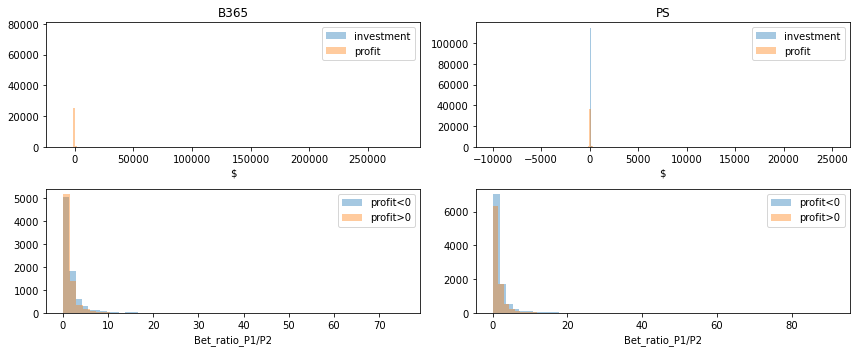

In [466]:
dist_revenue(matrix_j,C=0,S=3,max_bet=10000,model = 'SM4')

Let's see if that is the case, how the investment and the profit varies over the years, is it a stable strategy?

In [170]:
def revenue_year(matrix_j,C,S,max_bet,model = 'S'):
    
    if model == 'S1':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_S1(matrix_j,C,S,max_bet)
    elif model == 'S2':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_S2(matrix_j,C,S,max_bet)
    elif model == 'SM':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_SM(matrix_j,C,S,max_bet)
    elif model == 'SM2':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_SM2(matrix_j,C,S,max_bet)
    elif model == 'SM3':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_SM3(matrix_j,C,S,max_bet)
    elif model == 'SM4':
        PR_b365,PR_ps,total_invest_b365,total_invest_ps, total_prf_b365,total_prf_ps,invest,profit,matrix_com = revenue_SM4(matrix_j,C,S,max_bet)

    invest_year_PS = matrix_com[matrix_com.invest_PS>0].groupby(['year'])['invest_PS'].sum()
    profit_year_PS = matrix_com[matrix_com.invest_PS>0].groupby(['year'])['profit_PS'].sum()
    PR_year_PS = profit_year_PS/invest_year_PS 
    num_year_PS = matrix_com[matrix_com.invest_PS>0].groupby(['year'])['invest_PS'].count()
    
    invest_year_B365 = matrix_com[matrix_com.invest_B365>0].groupby(['year'])['invest_B365'].sum()
    profit_year_B365 = matrix_com[matrix_com.invest_B365>0].groupby(['year'])['profit_B365'].sum()
    PR_year_B365 = profit_year_B365/invest_year_B365 
    num_year_B365 = matrix_com[matrix_com.invest_B365>0].groupby(['year'])['invest_B365'].count()

    plt.figure(figsize = (12,8))
    ax1 = plt.subplot(2,2,1)
    ax1.bar(invest_year_B365.index,invest_year_B365.values,color = (0.3,0.6,0.3,0.8))
    ax2 = ax1.twinx()
    ax2.plot(invest_year_B365.index,num_year_B365.values,'*-',color = 'blue')
    plt.title('B365 - investment ($) & number of bets ')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('invest ($)',color = 'green',fontsize = 15)
    ax2.set_ylabel('number of bet',color = 'blue',fontsize = 15)
    plt.grid()

    #plt.subplot(1,2,2)
    ax1 = plt.subplot(2,2,3)
    ax1.bar(invest_year_B365.index,profit_year_B365.values,color = (0.8,0.6,0.3,0.8))
    ax2 = ax1.twinx()
    ax2.plot(invest_year_B365.index,100*PR_year_B365.values,'*-',color = 'red')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('profit ($)',color = 'orange',fontsize = 15)
    ax2.set_ylabel('profit rate (%)',color = 'red',fontsize = 15)

    plt.title('B365 - profit ($) and profit rate (%)')
    plt.grid()
    
    ax1 = plt.subplot(2,2,2)
    ax1.bar(invest_year_PS.index,invest_year_PS.values,color = (0.3,0.6,0.3,0.8))
    ax2 = ax1.twinx()
    ax2.plot(invest_year_PS.index,num_year_PS.values,'*-',color = 'blue')
    plt.title('PS - investment ($) & number of bets ')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('invest ($)',color = 'green',fontsize = 15)
    ax2.set_ylabel('number of bet',color = 'blue',fontsize = 15)
    plt.grid()

    #plt.subplot(1,2,2)
    ax1 = plt.subplot(2,2,4)
    ax1.bar(invest_year_PS.index,profit_year_PS.values,color = (0.8,0.6,0.3,0.8))
    ax2 = ax1.twinx()
    ax2.plot(invest_year_PS.index,100*PR_year_PS.values,'*-',color = 'red')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('profit ($)',color = 'orange',fontsize = 15)
    ax2.set_ylabel('profit rate (%)',color = 'red',fontsize = 15)

    plt.title('PS - profit ($) and profit rate (%)')
    plt.grid()
    plt.tight_layout()
    
    return



Betting model "S1", C=-0.85,S=-30


C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


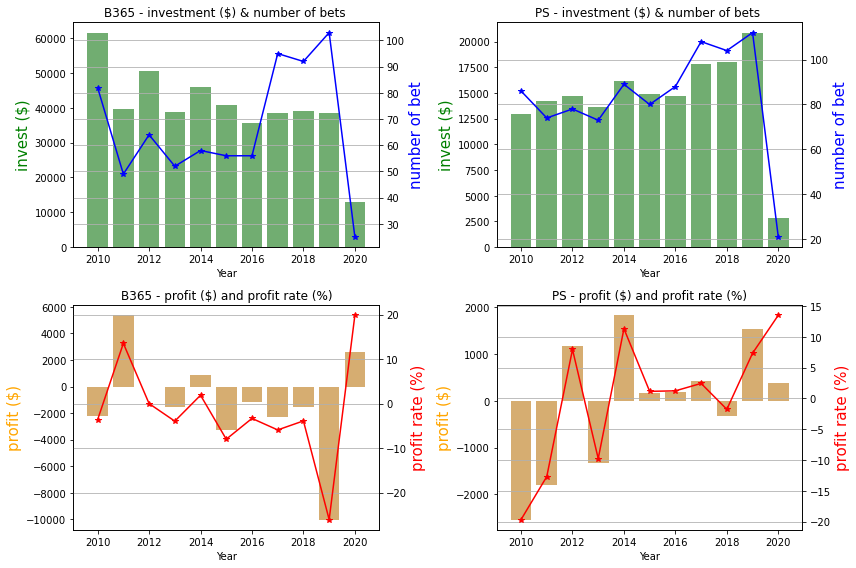

In [171]:
print('Betting model "S1", C=-0.85,S=-30')
revenue_year(matrix_j,C=-0.85,S=-20,max_bet=1000,model = 'S1')

Betting model "SM1", C=-1,S=-40


C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


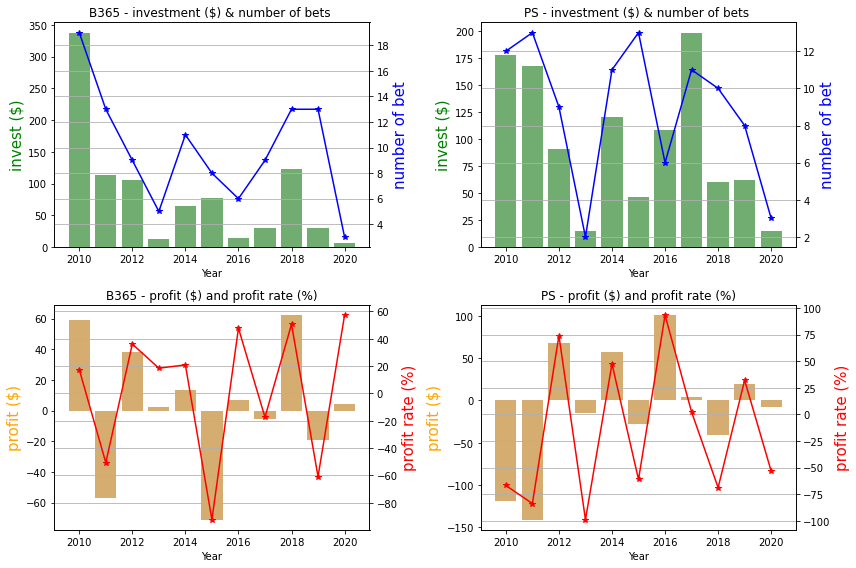

In [172]:
print('Betting model "SM1", C=-1,S=-40')
revenue_year(matrix_j,C=-1,S=-40,max_bet=100,model = 'SM2') 

Betting model "SM3", C=-1,S=-40


C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


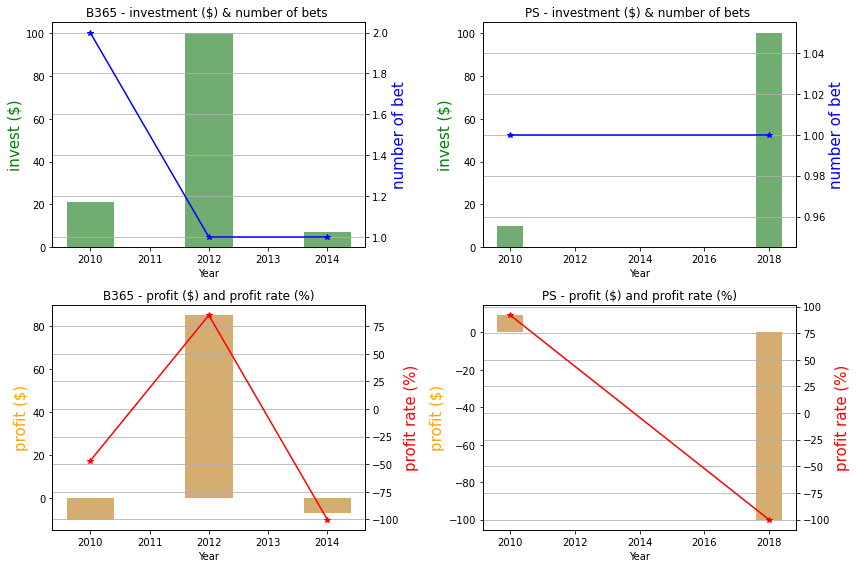

In [173]:
print('Betting model "SM3", C=-1,S=-40')
revenue_year(matrix_j,C=-2,S=-40,max_bet=100,model = 'SM3') 

Eventhough the total profit could be positive, the profit is very volatile from year to year. Interestingly, both the number of bet and investment gradually increase over the year, meaning that there are more highly uncertain games over the recent years.

In comparison, if we choose to invest more on highly certain games, the profit rate is more stable over the years, but overall the profit is very low.

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


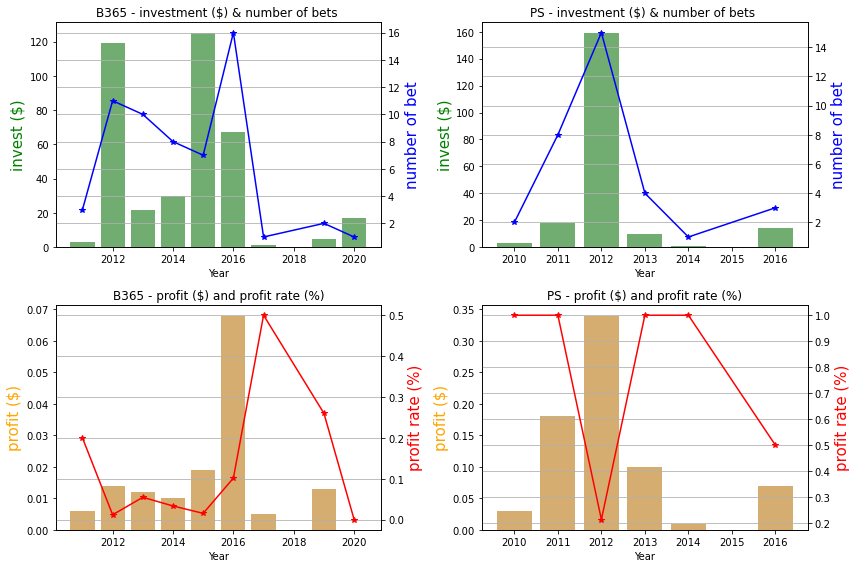

In [174]:
revenue_year(matrix_j,C=0,S=6.6,max_bet=100,model = 'S1')

To summarize the performance of different betting strategy:

In [175]:
summary

,Strategy_code,Strategy,Ann.PR_ave_B365 (%),Ann.PR_ave_PS (%),C,S
0,C1,A constant bet on players with smaller odds,-0.709235,-0.280669,NaN,NaN
1,C2,A constant bet on players with larger odds,-1.187440,-0.545003,NaN,NaN
2,C3,A constant bet on both sides,-0.970457,-0.414811,NaN,NaN
3,S1,Bet (O_2/O_1 + C)^S on p1 when O_2/O_1 > 1,-0.609065,0.614508,-0.85,-20.0
4,S2,"Bet (O_2/O_1 + C)^S on p1, and 1 on p2 when O_...",-0.609065,0.614508,-0.85,-20.0
5,SM1,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1>p_2,-0.482294,0.553304,-0.85,-20.0
6,SM2,Bet (O_2/O_1 + C)^S on p1 when O_2>O_1 & p_1<p_2,0.962800,2.877291,-1.00,-40.0
7,SM3,Bet (O_2/O_1 +p_1/P_2+ C)^S on p1 when O_2>O_1...,8.847204,-12.500000,-2.00,-40.0
8,SM4,Bet (p_1 O_1+ C)^S on p1 when O_2>O_1 & p_1>1/O_1,-0.665376,0.072102,-0.50,10.0
9,SM5,Bet B on p1 to maximize the ratio of profit ex...,-0.007009,-0.003318,NaN,NaN


<a id='summary'></a>
 ##  6. [Summary](#Contents)

* We have tested 10 strategies of betting on tennis using the data from 2012 to 2020.

* In general, it is difficult to get profit from the bookmakers in the long term.

* Intuitively, one should bet more on highly certain games, but it turns out that this stradegy is not efficient: the long-term profit rate is very low and the overall profit is subtile and could be negative. There is no benifit to bet on highly certain games in the long term since the annual profit rate is lower than fix-term deposit in the bank.

* Surprisingly, result shows that if we bet on highly uncertain games, i.e. when the probability of winning is around 50/50, it is possible to catch an opportunity and get a noticeable profit. However, the performance of such investment is very volatile over the years, due to the high uncertainty of the outcome, meaning this betting strategy is very risky if bet with a large amount of money.

### To conclude, sports betting is a good business, but just for bookmakers.